In [1]:
import json
from typing import List, Tuple
import contextlib
import io

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from PIL import Image

from src.blip_modules.blip_text_encoder import BLIPTextEncoder
from src.blip_modules.blip_img_encoder import BLIPImgEncoder
from src.data_utils import FashionIQDataset, targetpad_transform
from src.utils import extract_index_features, device, extract_index_features_with_text_captions
from src.validate import generate_fiq_val_predictions

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Modify the function for calculation in different alpha values</div>

# <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform alpha search for the best alpha value after the search and index were encoded</div>

In [2]:
@contextlib.contextmanager
def suppress_output():
    with io.StringIO() as buf, contextlib.redirect_stdout(buf), contextlib.redirect_stderr(buf):
        yield

# Define the decorator to suppress output of the function and any functions it calls
def suppress_function_output(func):
    def wrapper(*args, **kwargs):
        with suppress_output():
            return func(*args, **kwargs)
    return wrapper

In [3]:
def compute_fiq_val_metrics_text_image_modified(
    relative_val_dataset: FashionIQDataset,
    blip_text_encoder: torch.nn.Module,
    multiple_text_index_features: List[torch.tensor],
    multiple_text_index_names: List[List[str]],
    image_index_features: torch.tensor,
    image_index_names: List[str],
    combining_function: callable
) -> pd.DataFrame:
    """
    Compute validation metrics on FashionIQ dataset combining text and image distances.

    :param relative_val_dataset: FashionIQ validation dataset in relative mode
    :param blip_text_encoder: BLIP model
    :param multiple_text_index_features: validation index features from text
    :param multiple_text_index_names: validation index names from text
    :param image_index_features: validation image index features
    :param image_index_names: validation image index names
    :param combining_function: function that combines features
    :return: the computed validation metrics
    """
    all_text_distances = []
    results = []
    alphas = np.arange(0, 1.05, 0.05)
    target_names = None

    # Compute distances for individual text features
    for text_features, text_names in zip(multiple_text_index_features, multiple_text_index_names):
        # Generate text predictions and normalize features
        predicted_text_features, target_names = generate_fiq_val_predictions(
            blip_text_encoder, relative_val_dataset,
            combining_function, text_names, text_features)
        # Normalize features
        text_features = F.normalize(text_features, dim=-1)
        predicted_text_features = F.normalize(predicted_text_features, dim=-1)

        # Compute cosine similarity and convert to distance
        cosine_similarities = torch.mm(predicted_text_features, text_features.T)
        distances = 1 - cosine_similarities
        all_text_distances.append(distances)

    # Normalize and compute distances for image features if available
    if image_index_features is not None and len(image_index_features) > 0:
        predicted_image_features, _ = generate_fiq_val_predictions(blip_text_encoder, relative_val_dataset,
                                                                   combining_function, image_index_names,
                                                                   image_index_features)

        # Normalize and compute distances
        image_index_features = F.normalize(image_index_features, dim=-1).float()
        image_distances = 1 - predicted_image_features @ image_index_features.T
    else:
        image_distances = torch.zeros_like(all_text_distances[0])

    # Merge text distances
    merged_text_distances = torch.mean(torch.stack(all_text_distances), dim=0)

    # Iterating over alpha values
    for alpha in alphas:
        merged_distances = alpha * merged_text_distances + (1 - alpha) * image_distances
        sorted_indices = torch.argsort(merged_distances, dim=-1).cpu()
        sorted_index_names = np.array(image_index_names if image_index_names else multiple_text_index_names[0])[sorted_indices]
        labels = torch.tensor(
            sorted_index_names == np.repeat(np.array(target_names), len(image_index_names if image_index_names else multiple_text_index_names[0])).reshape(len(target_names), -1))
        assert torch.equal(torch.sum(labels, dim=-1).int(), torch.ones(len(target_names)).int())
        recall_at10 = (torch.sum(labels[:, :10]) / len(labels)).item() * 100
        recall_at50 = (torch.sum(labels[:, :50]) / len(labels)).item() * 100
        results.append({"alpha": alpha, "recall_at10": recall_at10, "recall_at50": recall_at50})

    return pd.DataFrame(results)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">The only diffence is remove alpha parameter from the function</div>

In [4]:
cache = {}

@suppress_function_output
def fashioniq_val_retrieval_text_image_modified(
    dress_type: str,
    combining_function: callable,
    blip_text_encoder: torch.nn.Module,
    blip_img_encoder: torch.nn.Module,
    text_captions: List[dict],
    preprocess: callable):
    """
    Perform retrieval on FashionIQ validation set computing the metrics. To combine the features the `combining_function`
    is used
    :param dress_type: FashionIQ category on which perform the retrieval
    :param combining_function:function which takes as input (image_features, text_features) and outputs the combined  features
    :param blip_text_encoder: BLIP text model
    :param blip_img_encoder: BLIP image model
    :param text_captions: text captions for the FashionIQ dataset
    :param preprocess: preprocess pipeline
    """
    global cache
    cache_key = f"{dress_type}_cache"
    
    blip_text_encoder = blip_text_encoder.float().eval()
    blip_img_encoder = blip_img_encoder.float().eval()
    
    if cache_key not in cache:
        # Define the validation datasets and extract the index features
        classic_val_dataset = FashionIQDataset('val', [dress_type], 'classic', preprocess)
    
        multiple_index_features, multiple_index_names = [], []
    
        for i in range(3):
            index_features, index_names, _ = extract_index_features_with_text_captions(
                classic_val_dataset,
                blip_text_encoder,
                text_captions,
                i + 1
            )
            multiple_index_features.append(index_features)
            multiple_index_names.append(index_names)
    
        image_index_features, image_index_names = extract_index_features(classic_val_dataset, blip_img_encoder)
        
        cache[cache_key] = {
            "multiple_index_features": multiple_index_features,
            "multiple_index_names": multiple_index_names,
            "image_index_features": image_index_features,
            "image_index_names": image_index_names
        }
    else:
        multiple_index_features = cache[cache_key]["multiple_index_features"]
        multiple_index_names = cache[cache_key]["multiple_index_names"]
        image_index_features = cache[cache_key]["image_index_features"]
        image_index_names = cache[cache_key]["image_index_names"]

    relative_val_dataset = FashionIQDataset('val', [dress_type], 'relative', preprocess)

    return compute_fiq_val_metrics_text_image_modified(
        relative_val_dataset,
        blip_text_encoder,
        multiple_index_features,
        multiple_index_names,
        image_index_features,
        image_index_names,
        combining_function
    )

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the BLIP model and the Combiner</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [5]:
BLIP_PRETRAINED_PATH = '../models/model_large.pth'
MED_CONFIG_PATH = 'blip_modules/med_config_large.json'

In [6]:
blip_text_encoder = BLIPTextEncoder(
    BLIP_PRETRAINED_PATH, 
    MED_CONFIG_PATH,
    use_pretrained_proj_layer=True,
    vit='large'
)

blip_text_encoder = blip_text_encoder.to(device)
print("blip text encoder loaded.")
blip_text_encoder.eval()

load checkpoint from ../models/model_large.pth for text_encoder.
load checkpoint from ../models/model_large.pth for text_proj.


blip text encoder loaded.

BLIPTextEncoder(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Drop

In [7]:
blip_img_encoder = BLIPImgEncoder(BLIP_PRETRAINED_PATH, vit='large')
blip_img_encoder = blip_img_encoder.to(device)
print("blip img encoder loaded.")
blip_img_encoder = blip_img_encoder.eval()

reshape position embedding from 196 to 576
load checkpoint from ../models/model_large.pth for visual_encoder.
load checkpoint from ../models/model_large.pth for vision_proj.


blip img encoder loaded.

In [8]:
print('Target pad preprocess pipeline is used')
preprocess = targetpad_transform(1.25, 384)

Target pad preprocess pipeline is used

In [9]:
def element_wise_sum_original(image_features: torch.tensor, text_features: torch.tensor) -> torch.tensor:
    """
    Normalized element-wise sum of image features and text features
    :param image_features: non-normalized image features
    :param text_features: non-normalized text features
    :return: normalized element-wise sum of image and text features
    """
    return F.normalize(image_features + text_features, dim=-1)

In [10]:
combining_function_original = element_wise_sum_original

In [11]:
def element_wise_sum(image_features: torch.tensor, text_features: torch.tensor, beta=0.65) -> torch.tensor:
    """
    Normalized element-wise sum of image features and text features
    :param image_features: non-normalized image features
    :param text_features: non-normalized text features
    :param beta: weight for text features
    :return: normalized element-wise sum of image and text features
    """
    return F.normalize((1 - beta) * image_features + beta * text_features, dim=-1)

In [12]:
combining_function = lambda image_features, text_features: element_wise_sum(image_features, text_features, beta=0.65)

In [13]:
def get_combing_function_with_beta(beta: float):
    return lambda image_features, text_features: element_wise_sum(image_features, text_features, beta=beta)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions and perform retrieval on the FashionIQ dataset</div>

In [14]:
with open('../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the function to convert the list of DataFrames to a single DataFrame with a pivot table structure</div>

In [15]:
def convert_to_pivot(data: List[pd.DataFrame]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Convert a list of DataFrames to a single DataFrame with a pivot table structure.
    :param data: list of DataFrames
    :return: a single DataFrame with a pivot table structure
    """
    concatenated_data = []
    betas = np.arange(0, 1.05, 0.05)

    # Concatenate dataframes for all betas and add beta_index, beta_df in enumerate(data):
    for beta_index, beta_df in enumerate(data):
        beta_df['beta'] = round(betas[beta_index], 2)  # Round to two decimal places
        concatenated_data.append(beta_df)

    # Create one dataframe per category
    category_df = pd.concat(concatenated_data, ignore_index=True)
    
    # Create pivot tables for recall@10 and recall@50
    recall_at10 = category_df.pivot_table(index='alpha', columns='beta', values='recall_at10')
    recall_at50 = category_df.pivot_table(index='alpha', columns='beta', values='recall_at50')
    
    return recall_at10, recall_at50

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [16]:
grid_search_betas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for beta in tqdm(grid_search_betas, desc="Grid Search Betas"):
    shirt_recall = fashioniq_val_retrieval_text_image_modified(
        'shirt',
        get_combing_function_with_beta(beta),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess
    )
    
    shirt_recall_list.append(shirt_recall)

shirt_recall_at10, shirt_recall_at50 = convert_to_pivot(shirt_recall_list)

Grid Search Betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [17]:
shirt_recall_at10

beta       0.00      0.05      0.10      0.15      0.20      0.25       0.30  \
alpha                                                                          
0.00   8.243376  8.243376  8.292443  8.292443  8.341511  8.341511   8.390579   
0.05   8.390579  8.439647  8.390579  8.439647  8.488715  8.586850   8.586850   
0.10   8.537782  8.488715  8.586850  8.635917  8.881256  8.881256   8.979391   
0.15   8.488715  8.635917  8.734053  8.832189  8.979391  8.979391   9.077527   
0.20   8.537782  8.586850  8.684985  8.734053  8.930324  8.979391   9.028459   
0.25   8.783121  8.783121  8.783121  8.734053  8.832189  9.126595   9.371933   
0.30   8.635917  8.684985  8.734053  8.930324  9.224730  9.273798   9.568204   
0.35   8.292443  8.488715  8.783121  8.979391  9.371933  9.617272   9.764475   
0.40   8.243376  8.439647  8.783121  8.930324  9.224730  9.715407  10.009813   
0.45   8.243376  8.390579  8.734053  8.832189  9.224730  9.568204   9.862611   
0.50   8.243376  8.341511  8.586850  8.979391  9.421001  9.568204   9.764475   
0.55   8.047105  8.096173  8.341511  8.635917  9.273798  9.421001   9.715407   
0.60   7.703631  8.047105  8.194308  8.488715  9.077527  9.519137   9.862611   
0.65   7.163886  7.507360  7.801767  8.243376  8.635917  9.175663   9.813543   
0.70   6.918547  6.967615  7.360157  7.850834  8.488715  8.979391   9.764475   
0.75   6.673209  6.967615  7.114819  7.409225  7.998037  9.126595   9.666339   
0.80   6.722277  6.771345  7.016683  7.360157  7.801767  8.734053   9.470069   
0.85   6.526006  6.722277  7.016683  7.409225  7.703631  7.998037   8.881256   
0.90   6.329735  6.526006  6.673209  7.016683  7.458293  7.703631   8.292443   
0.95   5.888126  6.084396  6.231600  6.575073  6.918547  7.360157   8.145241   
1.00   5.593719  5.691855  6.231600  6.182532  6.476938  7.065751   7.850834   

beta        0.35       0.40       0.45  ...       0.55       0.60       0.65  \
alpha                                   ...                                    
0.00    8.488715   8.635917   8.684985  ...   8.979391   9.175663   9.224730   
0.05    8.586850   8.734053   8.832189  ...   9.077527   9.224730   9.421001   
0.10    8.979391   9.028459   9.126595  ...   9.322865   9.371933   9.764475   
0.15    9.175663   9.322865   9.322865  ...   9.421001   9.617272   9.715407   
0.20    9.224730   9.322865   9.470069  ...   9.862611  10.107949  10.157017   
0.25    9.371933   9.568204   9.715407  ...  10.402355  10.942100  11.432777   
0.30    9.666339   9.911678  10.058881  ...  10.942100  11.481845  12.070657   
0.35   10.255152  10.451423  10.451423  ...  11.383709  11.972522  12.414131   
0.40   10.206085  10.598626  11.089303  ...  11.923455  12.217861  12.708537   
0.45   10.402355  10.942100  11.138371  ...  12.414131  13.002944  13.444553   
0.50   10.304220  11.040235  11.334642  ...  12.512267  13.150147  14.425908   
0.55   10.353287  11.089303  11.530913  ...  13.444553  13.788028  14.573111   
0.60   10.549559  11.432777  12.365064  ...  13.935231  14.180569  14.671247   
0.65   10.402355  11.187439  12.266929  ...  13.935231  14.376840  14.867517   
0.70   10.549559  11.432777  12.217861  ...  14.131501  14.376840  14.622179   
0.75   10.353287  11.138371  12.365064  ...  14.131501  14.524043  14.671247   
0.80    9.813543  10.696761  11.334642  ...  13.837095  14.327772  14.278704   
0.85    9.715407  10.451423  11.040235  ...  13.640824  14.327772  13.640824   
0.90    9.322865   9.911678  10.500491  ...  13.101080  13.493621  12.757605   
0.95    8.979391   9.322865  10.353287  ...  12.365064  12.414131  12.168793   
1.00    8.243376   8.930324   9.764475  ...  11.776251  11.383709  10.942100   

beta        0.70       0.75       0.80       0.85       0.90       0.95  \
alpha                                                                     
0.00    9.322865   9.617272  10.107949  11.383709  13.052012  18.792935   
0.05    9.568204  10.058881  10.451423  11.776251  13.984299  19.381747   
0.10    9.813543  

In [18]:
shirt_recall_at50

beta        0.00       0.05       0.10       0.15       0.20       0.25  \
alpha                                                                     
0.00   17.860648  17.909716  17.811580  18.105987  18.105987  18.253189   
0.05   18.155053  18.204121  18.400392  18.449460  18.498528  18.694799   
0.10   18.547596  18.743867  18.645731  18.842001  18.940137  19.136408   
0.15   18.498528  18.645731  18.842001  18.989205  19.234544  19.430815   
0.20   18.645731  18.743867  18.891069  19.234544  19.627085  20.117763   
0.25   18.743867  18.989205  19.087340  19.381747  19.872424  20.657508   
0.30   18.792935  19.087340  19.479883  19.970560  20.363101  21.000981   
0.35   19.038273  19.283612  19.774288  20.314033  20.755643  21.589793   
0.40   18.743867  19.528949  19.970560  20.363101  21.099117  21.589793   
0.45   18.743867  19.332679  19.725221  20.363101  21.050049  21.491659   
0.50   18.253189  18.743867  19.578017  20.363101  21.099117  21.736997   
0.55   17.860648  18.351325  19.136408  20.068695  21.099117  21.884200   
0.60   17.468105  18.253189  18.842001  19.872424  20.755643  21.491659   
0.65   17.124632  18.056919  19.038273  19.528949  20.363101  21.148184   
0.70   16.437684  17.026496  18.056919  19.234544  20.019627  20.755643   
0.75   15.996075  16.633955  17.419039  18.351325  19.430815  20.215897   
0.80   15.014720  15.456329  16.388616  17.075564  18.105987  19.332679   
0.85   13.640824  14.671247  15.260059  16.339548  17.566241  18.547596   
0.90   12.953876  13.640824  14.278704  15.309127  16.192345  17.369971   
0.95   12.512267  13.101080  13.444553  14.622179  15.260059  16.290481   
1.00   11.629048  12.168793  12.953876  13.788028  14.524043  15.505397   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   18.253189  18.253189  18.351325  18.596664  ...  18.792935  18.940137   
0.05   18.792935  18.891069  19.087340  19.332679  ...  19.627085  20.068695   
0.10   19.185476  19.283612  19.430815  20.019627  ...  20.559372  21.000981   
0.15   19.430815  19.872424  20.215897  20.363101  ...  21.246320  21.589793   
0.20   20.412169  20.853779  20.951913  21.246320  ...  21.786065  22.276741   
0.25   21.050049  21.344456  21.589793  22.031404  ...  22.963689  23.307164   
0.30   21.540727  21.884200  22.325809  22.669284  ...  23.748773  24.288519   
0.35   22.031404  22.522080  22.718351  23.405299  ...  24.239451  24.926399   
0.40   21.982336  22.374877  22.963689  23.846909  ...  25.024533  25.564280   
0.45   21.933268  22.669284  23.503435  24.190383  ...  25.466144  25.760549   
0.50   22.276741  22.963689  23.895976  24.631992  ...  26.496565  26.741904   
0.55   22.473013  23.209028  24.092247  25.269872  ...  26.692837  27.772325   
0.60   22.227675  22.963689  24.386653  25.220805  ...  27.085379  28.459275   
0.65   21.982336  22.914623  24.239451  25.269872  ...  27.625123  28.606477   
0.70   21.589793  22.865555  23.895976  25.368008  ...  27.526987  27.870461   
0.75   21.197252  22.227675  23.307164  25.073603  ...  27.183512  27.330717   
0.80   20.264965  21.589793  22.767419  24.779195  ...  26.398429  27.036309   
0.85   19.627085  21.148184  22.423945  23.846909  ...  25.858685  26.496565   
0.90   18.596664  20.510304  21.835132  23.110893  ...  24.926399  25.466144   
0.95   17.762512  19.430815  21.050049  22.571148  ...  24.043180  24.190383   
1.00   16.830225  18.302257  19.528949  21.540727  ...  22.473013  23.159961   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   19.332679  19.823356  20.461236  21.246320  23.012757  26.005888   
0.05   20.264965  20.706575  21.197252  22.227675  23.601571  26.889107   
0.10   21.246320  21.491659  21.933268  23.061825  24.631992  27.821395   
0.15   21.933268  22.522080  22.963689  24.043180  25.7114

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [19]:
grid_search_betas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for beta in tqdm(grid_search_betas, desc="Grid Search Betas"):
    dress_recall = fashioniq_val_retrieval_text_image_modified(
        'dress',
        get_combing_function_with_beta(beta),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot(dress_recall_list)

Grid Search Betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [20]:
dress_recall_at10

beta       0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
alpha                                                                         
0.00   4.015865  4.015865  4.015865  4.015865  4.164601  4.164601  4.263758   
0.05   4.115022  4.115022  4.115022  4.115022  4.164601  4.313337  4.313337   
0.10   3.867129  3.966286  4.065444  4.065444  4.214180  4.214180  4.313337   
0.15   4.065444  4.065444  4.214180  4.263758  4.362915  4.362915  4.462072   
0.20   3.817551  3.867129  4.015865  4.115022  4.164601  4.362915  4.511651   
0.25   3.668815  3.718394  3.817551  3.867129  4.015865  4.164601  4.313337   
0.30   3.420922  3.520079  3.619236  3.718394  3.867129  4.214180  4.214180   
0.35   3.321765  3.272187  3.321765  3.371344  3.767972  3.916708  4.164601   
0.40   3.272187  3.222608  3.272187  3.420922  3.619236  3.767972  4.065444   
0.45   3.470501  3.470501  3.470501  3.470501  3.668815  3.718394  3.867129   
0.50   3.321765  3.470501  3.569658  3.569658  3.767972  3.867129  3.966286   
0.55   2.974715  3.073872  3.470501  3.619236  3.718394  3.718394  3.966286   
0.60   2.974715  3.024293  3.173029  3.321765  3.569658  3.718394  3.718394   
0.65   2.974715  3.123451  3.073872  3.123451  3.073872  3.470501  3.619236   
0.70   2.578086  2.726822  2.776401  2.875558  2.776401  3.024293  3.371344   
0.75   2.627665  2.578086  2.528508  2.627665  2.677243  3.123451  3.024293   
0.80   2.379772  2.478929  2.578086  2.627665  2.578086  2.776401  3.024293   
0.85   2.330193  2.429350  2.478929  2.528508  2.478929  2.578086  2.875558   
0.90   2.280615  2.478929  2.429350  2.379772  2.429350  2.429350  2.726822   
0.95   2.131879  2.231036  2.231036  2.231036  2.231036  2.280615  2.528508   
1.00   2.131879  1.983143  1.933565  1.983143  2.032722  2.131879  2.429350   

beta       0.35      0.40      0.45  ...      0.55      0.60      0.65  \
alpha                                ...                                 
0.00   4.362915  4.462072  4.511651  ...  4.709965  4.759544  4.908280   
0.05   4.313337  4.561229  4.660387  ...  4.858701  4.957858  5.057015   
0.10   4.313337  4.313337  4.462072  ...  4.858701  5.007437  5.205751   
0.15   4.412494  4.412494  4.561229  ...  4.759544  5.156172  5.304908   
0.20   4.511651  4.561229  4.462072  ...  4.709965  5.205751  5.453644   
0.25   4.412494  4.462072  4.511651  ...  4.759544  5.205751  5.354487   
0.30   4.263758  4.660387  4.660387  ...  5.106594  5.255330  5.503223   
0.35   4.313337  4.511651  4.660387  ...  5.106594  5.156172  5.503223   
0.40   4.362915  4.660387  4.759544  ...  5.255330  5.255330  5.701537   
0.45   4.313337  4.660387  4.759544  ...  5.156172  5.354487  5.751115   
0.50   4.015865  4.412494  4.610808  ...  4.957858  5.354487  6.147744   
0.55   4.015865  4.313337  4.561229  ...  4.908280  5.751115  6.395637   
0.60   3.916708  3.966286  4.511651  ...  4.908280  5.602380  6.246901   
0.65   3.817551  3.867129  4.462072  ...  5.057015  5.503223  6.098166   
0.70   3.520079  3.867129  4.015865  ...  5.106594  5.651958  6.296480   
0.75   3.470501  3.668815  3.966286  ...  5.106594  5.701537  5.800694   
0.80   3.272187  3.569658  3.668815  ...  5.057015  5.354487  5.751115   
0.85   3.173029  3.520079  3.817551  ...  4.759544  5.205751  5.503223   
0.90   3.073872  3.420922  3.668815  ...  4.462072  4.957858  5.205751   
0.95   2.776401  3.272187  3.668815  ...  4.362915  4.809123  4.660387   
1.00   2.379772  3.024293  3.321765  ...  4.214180  4.412494  4.313337   

beta       0.70      0.75      0.80      0.85       0.90       0.95       1.00  
alpha                                                                           
0.00   5.007437  5.255330  5.651958  6.395637   7.932573  14.774418  12.741695  
0.05   5.106594  5.503223  5.850273  6.643530   8.824988  15.666832  13.287060  
0.10   5.304908  5.453644  5.999009  6.941001   9.320773  16.509669  13.584532  
0.15   5.453644  5.651958  6.098166  7.387209  10.213188  17.501239  13.93

In [21]:
dress_recall_at50

beta        0.00       0.05       0.10       0.15       0.20       0.25  \
alpha                                                                     
0.00   10.907288  11.056024  11.105602  11.105602  11.254338  11.452653   
0.05   11.056024  11.204760  11.204760  11.254338  11.403074  11.551809   
0.10   10.956866  11.105602  11.155181  11.254338  11.551809  11.502231   
0.15   10.956866  11.204760  11.204760  11.254338  11.551809  11.601388   
0.20   11.303917  11.502231  11.601388  11.551809  11.849281  12.295488   
0.25   11.403074  11.502231  11.502231  11.601388  11.998017  12.394646   
0.30   11.204760  11.303917  11.254338  11.650967  11.898860  12.196331   
0.35   11.105602  11.105602  11.403074  11.502231  11.799703  12.047596   
0.40   10.609817  10.808131  11.254338  11.353495  11.601388  12.047596   
0.45   10.461081  10.956866  11.105602  11.353495  11.601388  11.998017   
0.50   10.411502  10.560238  10.907288  11.105602  11.303917  11.849281   
0.55    9.965295  10.262766  10.609817  10.907288  11.155181  11.700545   
0.60    9.717402   9.866138  10.163610  10.411502  10.956866  11.403074   
0.65    9.519088   9.667823   9.915716  10.461081  10.808131  11.452653   
0.70    9.122459   9.370352   9.568667  10.064452  10.560238  11.056024   
0.75    8.775409   8.874566   9.320773   9.667823  10.064452  10.808131   
0.80    8.081309   8.626673   9.072880   9.469509   9.915716  10.163610   
0.85    7.833416   8.081309   8.527516   9.023302   9.717402  10.114031   
0.90    7.238473   7.734258   8.329201   9.072880   9.618245   9.766981   
0.95    6.891423   7.188895   7.932573   8.329201   9.072880   9.320773   
1.00    6.494794   6.941001   7.139315   7.585523   8.230045   8.874566   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   11.601388  11.799703  11.948438  12.047596  ...  12.295488  12.692118   
0.05   11.750124  11.898860  12.097174  12.245910  ...  12.741695  13.187903   
0.10   11.650967  11.948438  12.345067  12.592959  ...  13.187903  13.584532   
0.15   11.948438  12.295488  12.692118  13.088746  ...  13.733268  14.030738   
0.20   12.493803  12.642539  12.940010  13.435796  ...  14.229053  14.576103   
0.25   12.692118  12.890431  13.088746  13.435796  ...  14.377789  15.071888   
0.30   12.642539  13.039167  13.435796  13.882002  ...  15.022311  15.914725   
0.35   12.394646  12.940010  13.634109  14.328210  ...  15.617253  16.360933   
0.40   12.493803  13.039167  13.832425  14.625682  ...  15.914725  16.906297   
0.45   12.444224  13.138324  13.634109  14.526525  ...  16.113040  17.402083   
0.50   12.493803  12.890431  13.733268  14.774418  ...  16.658403  17.798711   
0.55   12.345067  12.791274  13.534953  14.476946  ...  17.104611  18.145761   
0.60   12.196331  12.840852  13.534953  14.526525  ...  16.955875  18.195340   
0.65   12.097174  12.543382  13.435796  14.377789  ...  16.807139  18.046604   
0.70   11.700545  12.543382  13.237481  14.129896  ...  16.707982  17.798711   
0.75   11.353495  12.047596  12.989588  14.129896  ...  16.113040  17.451660   
0.80   10.808131  11.551809  12.592959  13.634109  ...  15.666832  16.608825   
0.85   10.510659  11.204760  11.898860  13.138324  ...  14.972731  15.716411   
0.90   10.312345  10.262766  11.056024  11.898860  ...  14.030738  14.476946   
0.95    9.469509   9.866138  10.411502  11.601388  ...  13.237481  13.534953   
1.00    8.874566   9.271195   9.667823  11.056024  ...  12.047596  12.890431   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   13.088746  13.485375  13.882002  15.468517  17.104611  20.723847   
0.05   13.634109  14.179474  14.873575  16.113040  17.947447  22.657412   
0.10   14.129896  14.823996  15.468517  16.906297  19.038175  23.996034   
0.15   14.923154  15.319782  16.212197  17.798711  20.4759

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [23]:
grid_search_betas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for beta in tqdm(grid_search_betas, desc="Grid Search Betas"):
    toptee_recall = fashioniq_val_retrieval_text_image_modified(
        'toptee',
        get_combing_function_with_beta(beta),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot(toptee_recall_list)

Grid Search Betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [24]:
toptee_recall_at10

beta       0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
alpha                                                                         
0.00   6.323305  6.323305  6.272310  6.221316  6.221316  6.323305  6.323305   
0.05   6.119327  6.272310  6.272310  6.323305  6.323305  6.476288  6.578276   
0.10   6.068332  6.068332  6.170321  6.221316  6.374299  6.578276  6.578276   
0.15   6.425294  6.476288  6.476288  6.425294  6.527282  6.527282  6.629271   
0.20   6.374299  6.374299  6.476288  6.578276  6.731260  6.731260  6.731260   
0.25   6.425294  6.425294  6.476288  6.629271  6.731260  6.782254  6.986231   
0.30   5.915349  6.119327  6.425294  6.833249  7.037226  7.139215  7.292198   
0.35   5.966344  6.119327  6.221316  6.323305  6.833249  7.241204  7.445181   
0.40   5.864355  6.170321  6.425294  6.680265  6.884243  7.088220  7.394186   
0.45   5.711372  5.813361  6.272310  6.425294  6.782254  7.241204  7.649159   
0.50   5.660377  5.915349  6.374299  6.425294  6.884243  7.241204  7.649159   
0.55   5.456400  5.660377  5.966344  6.527282  6.884243  7.241204  7.700153   
0.60   5.048444  5.354411  5.762366  6.272310  6.731260  7.037226  7.547170   
0.65   4.640489  4.946456  5.354411  6.017338  6.374299  6.935237  7.445181   
0.70   4.538501  4.742478  4.793473  5.507394  5.915349  6.629271  7.496175   
0.75   4.130546  4.283529  4.844467  5.150434  5.864355  6.425294  7.343192   
0.80   4.079551  4.181540  4.742478  5.099439  5.660377  6.119327  6.833249   
0.85   3.926568  4.130546  4.487506  4.844467  5.201428  6.017338  6.731260   
0.90   3.926568  4.130546  4.334523  4.589495  5.150434  5.762366  6.425294   
0.95   3.467619  3.773585  4.028557  4.232534  4.793473  5.150434  6.017338   
1.00   3.008669  3.161652  3.773585  4.130546  4.436512  4.793473  5.303417   

beta       0.35      0.40       0.45  ...       0.55       0.60       0.65  \
alpha                                 ...                                    
0.00   6.323305  6.425294   6.629271  ...   6.833249   6.935237   7.037226   
0.05   6.680265  6.833249   6.782254  ...   6.986231   7.190209   7.394186   
0.10   6.578276  6.629271   6.833249  ...   7.190209   7.649159   8.006119   
0.15   6.629271  6.782254   7.088220  ...   7.649159   8.159102   8.618052   
0.20   6.833249  7.088220   7.343192  ...   8.210097   8.567058   9.331974   
0.25   7.241204  7.496175   8.006119  ...   8.924019   9.484956   9.790923   
0.30   7.445181  8.006119   8.363080  ...   9.178990   9.790923  10.147884   
0.35   7.751147  8.363080   8.924019  ...   9.688934  10.249873  10.759816   
0.40   7.955125  8.567058   9.127996  ...  10.096889  10.606834  11.320755   
0.45   8.261091  8.873024   9.229985  ...  10.504845  11.167771  12.187659   
0.50   8.312086  8.822030   9.433962  ...  10.912800  11.881693  12.901580   
0.55   8.465069  9.127996   9.382968  ...  11.320755  12.442631  13.513513   
0.60   8.720041  9.077001   9.892911  ...  11.830699  13.105558  14.125445   
0.65   8.822030  9.484956   9.790923  ...  12.340643  13.666497  14.278430   
0.70   8.414075  9.229985  10.147884  ...  12.238654  13.411525  14.023457   
0.75   7.955125  9.127996  10.249873  ...  12.340643  13.513513  13.819480   
0.80   7.853136  8.720041   9.841917  ...  12.085670  13.003570  13.564508   
0.85   7.751147  8.618052   9.688934  ...  11.575726  12.238654  12.595615   
0.90   7.751147  8.261091   9.229985  ...  10.759816  11.881693  11.626721   
0.95   7.037226  7.904130   8.771035  ...  10.402856  10.453850  10.351861   
1.00   6.680265  7.445181   8.516064  ...   9.994900  10.045895   9.790923   

beta        0.70       0.75       0.80       0.85       0.90       0.95  \
alpha                                                                     
0.00    7.496175   7.853136   8.465069   9.841917  12.952575  20.703723   
0.05    7.751147   8.210097   9.382968  10.963794  14.074452  21.570627   
0.10    8.414075   9.026007  10.708822  11.626721  15.298317  22.488527   
0.15    9.07

In [25]:
toptee_recall_at50

beta        0.00       0.05       0.10       0.15       0.20       0.25  \
alpha                                                                     
0.00   15.349312  15.451300  15.553290  15.706272  15.808260  15.910250   
0.05   15.400305  15.451300  15.655278  15.757267  15.961245  16.216215   
0.10   15.706272  15.910250  15.961245  16.216215  16.471188  16.624172   
0.15   15.961245  16.114227  16.267210  16.522183  16.879143  16.981132   
0.20   16.063233  16.420195  16.522183  16.624172  16.828150  17.236105   
0.25   15.604283  16.012238  16.369200  16.573177  17.032127  17.338093   
0.30   15.706272  16.012238  16.267210  16.624172  17.185110  17.695053   
0.35   15.298317  15.859255  16.318205  16.522183  17.338093  17.950025   
0.40   15.247323  15.553290  16.114227  16.624172  17.236105  17.746048   
0.45   14.839368  15.349312  16.318205  16.828150  17.389087  17.950025   
0.50   14.788373  15.349312  16.216215  16.675165  17.389087  18.001020   
0.55   13.870475  14.941357  15.706272  16.522183  16.981132  17.746048   
0.60   13.360530  13.921468  15.043345  15.859255  16.471188  17.695053   
0.65   12.850587  13.360530  14.278430  15.349312  16.369200  17.083120   
0.70   12.391637  12.952575  13.513513  14.839368  16.216215  17.032127   
0.75   12.136665  12.595615  13.054565  14.125445  15.808260  16.726160   
0.80   11.371749  12.136665  12.850587  13.717490  14.992350  16.063233   
0.85   10.708822  11.014789  11.932687  13.207547  14.380418  15.247323   
0.90   10.147884  10.657828  11.524732  12.391637  13.258542  14.533402   
0.95    9.739929  10.198878  10.861805  11.779704  12.799592  14.176440   
1.00    9.382968   9.790923  10.300867  11.371749  12.238654  13.870475   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   15.961245  16.063233  16.267210  16.471188  ...  16.879143  17.236105   
0.05   16.420195  16.522183  16.726160  17.134115  ...  17.644060  18.154003   
0.10   16.828150  16.981132  17.236105  17.440082  ...  18.255992  18.714942   
0.15   17.083120  17.134115  17.644060  17.899030  ...  19.326875  19.785823   
0.20   17.338093  17.848037  18.306985  18.867925  ...  20.193778  21.060683   
0.25   17.746048  18.255992  18.816930  19.734830  ...  21.264660  22.131565   
0.30   18.204997  18.918920  19.734830  20.499745  ...  22.539520  23.355430   
0.35   18.408975  19.326875  20.193778  21.417645  ...  23.406425  24.630290   
0.40   18.765935  19.887812  20.550740  21.774605  ...  24.375318  26.160121   
0.45   18.561958  19.836818  21.264660  22.539520  ...  25.293219  27.332994   
0.50   18.765935  20.040795  21.417645  22.998470  ...  25.956145  27.689955   
0.55   18.816930  20.295767  21.162672  23.100460  ...  26.568079  27.842936   
0.60   18.663947  20.142785  21.621622  23.355430  ...  26.772055  28.607854   
0.65   18.867925  20.142785  21.774605  23.508415  ...  26.772055  28.352880   
0.70   18.714942  19.683835  21.570627  23.304437  ...  26.823050  27.587965   
0.75   18.103008  19.020908  20.907700  22.896482  ...  26.058134  27.791944   
0.80   17.185110  19.020908  20.601735  22.947475  ...  25.905150  27.893931   
0.85   16.828150  18.714942  20.448750  22.437532  ...  25.701174  27.129015   
0.90   16.063233  18.306985  20.346762  21.723610  ...  24.987252  26.007140   
0.95   15.502295  17.440082  19.632840  21.111678  ...  24.222335  25.089240   
1.00   14.686385  16.573177  18.612953  20.295767  ...  23.967363  23.763385   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   17.746048  18.663947  19.581845  20.193778  23.406425  27.536970   
0.05   18.561958  19.326875  20.091790  21.723610  24.783275  29.321775   
0.10   19.479857  20.091790  21.111678  23.202448  26.109129  30.545640   
0.15   20.703723  21.417645  22.896482  24.987252  27.4349

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [26]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [27]:
print("Average Recall@10 for each alpha across all betas:")
average_recall_at10

Average Recall@10 for each alpha across all betas:

beta       0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
alpha                                                                         
0.00   6.194182  6.194182  6.193540  6.176541  6.242476  6.276472  6.325880   
0.05   6.208309  6.275660  6.259304  6.292658  6.325540  6.458825  6.492821   
0.10   6.157748  6.174445  6.274205  6.307559  6.489911  6.557904  6.623668   
0.15   6.326484  6.392549  6.474840  6.507080  6.623196  6.623196  6.722957   
0.20   6.243211  6.276093  6.392379  6.475784  6.608728  6.691189  6.757123   
0.25   6.292410  6.308936  6.358986  6.410151  6.526438  6.691150  6.890500   
0.30   5.990730  6.108131  6.259528  6.493989  6.709695  6.875731  7.024860   
0.35   5.860184  5.960076  6.108734  6.224680  6.657718  6.925061  7.124752   
0.40   5.793306  5.944192  6.160200  6.343837  6.576070  6.857200  7.156481   
0.45   5.808416  5.891480  6.158954  6.242661  6.558600  6.842600  7.126300   
0.50   5.741839  5.909120  6.176936  6.324781  6.691072  6.892179  7.126640   
0.55   5.492740  5.610141  5.926119  6.260812  6.625478  6.793533  7.127282   
0.60   5.242264  5.475270  5.709901  6.027597  6.459481  6.758252  7.042725   
0.65   4.926363  5.192422  5.410017  5.794722  6.028029  6.527134  6.959320   
0.70   4.678378  4.812305  4.976677  5.411262  5.726822  6.210985  6.877331   
0.75   4.477140  4.609743  4.829264  5.062441  5.513212  6.225113  6.677942   
0.80   4.393867  4.477271  4.779083  5.029087  5.346743  5.876593  6.442537   
0.85   4.260922  4.427391  4.661040  4.927400  5.127996  5.531154  6.162691   
0.90   4.178973  4.378494  4.479028  4.661983  5.012692  5.298449  5.814853   
0.95   3.829208  4.029672  4.163731  4.346215  4.647685  4.930402  5.563695   
1.00   3.578089  3.612217  3.979583  4.098740  4.315391  4.663701  5.194534   

beta       0.35      0.40      0.45  ...       0.55       0.60       0.65  \
alpha                                ...                                    
0.00   6.391645  6.507761  6.608636  ...   6.840868   6.956815   7.056745   
0.05   6.526817  6.709510  6.758276  ...   6.974153   7.124266   7.290734   
0.10   6.623668  6.657022  6.807305  ...   7.123925   7.342843   7.658782   
0.15   6.739143  6.839204  6.990772  ...   7.276568   7.644182   7.879456   
0.20   6.856543  6.990772  7.091778  ...   7.594224   7.960252   8.314211   
0.25   7.008544  7.175484  7.411059  ...   8.028639   8.544269   8.859396   
0.30   7.125093  7.526061  7.694116  ...   8.409228   8.842699   9.240588   
0.35   7.439879  7.775385  8.011943  ...   8.726412   9.126189   9.559057   
0.40   7.508042  7.942023  8.325614  ...   9.091891   9.360008   9.910276   
0.45   7.658928  8.158503  8.375966  ...   9.358383   9.841734  10.461109   
0.50   7.544057  8.091586  8.459804  ...   9.460975  10.128775  11.158411   
0.55   7.611407  8.176879  8.491703  ...   9.891196  10.660592  11.494087   
0.60   7.728769  8.158688  8.923209  ...  10.224736  10.962836  11.681198   
0.65   7.680645  8.179841  8.839975  ...  10.444296  11.182187  11.748038   
0.70   7.494571  8.176630  8.793870  ...  10.492250  11.146774  11.647372   
0.75   7.259638  7.978394  8.860408  ...  10.526246  11.246364  11.430474   
0.80   6.979622  7.662153  8.281791  ...  10.326593  10.895276  11.198109   
0.85   6.879861  7.529851  8.182240  ...   9.992031  10.590726  10.579887   
0.90   6.715962  7.197897  7.799763  ...   9.440990  10.111057   9.863359   
0.95   6.264339  6.833061  7.597712  ...   9.043612   9.225701   9.060347   
1.00   5.767804  6.466600  7.200768  ...   8.661777   8.614033   8.348786   

beta        0.70       0.75       0.80       0.85       0.90       0.95  \
alpha                                                                     
0.00    7.275492   7.575246   8.074992   9.207088  11.312387  18.090358   
0.05    7.475315   7.924067   8.561554   9.794525  12.294580  18.873069   
0.10    7.844175   8.212223   9.233000  10.359996  13.113135  19.688963   
0.15    8.212865   8.845346   9.712

In [28]:
print("Average Recall@50 for each alpha across all betas:")
average_recall_at50

Average Recall@50 for each alpha across all betas:

beta        0.00       0.05       0.10       0.15       0.20       0.25  \
alpha                                                                     
0.00   14.705749  14.805680  14.823491  14.972620  15.056195  15.205364   
0.05   14.870461  14.953394  15.086810  15.153688  15.287616  15.487608   
0.10   15.070245  15.253240  15.254052  15.437518  15.654378  15.754270   
0.15   15.138880  15.321573  15.437990  15.588575  15.888499  16.004445   
0.20   15.337627  15.555431  15.671547  15.803508  16.101505  16.549785   
0.25   15.250408  15.501225  15.652924  15.852104  16.300856  16.796749   
0.30   15.234656  15.467831  15.667144  16.081900  16.482357  16.964122   
0.35   15.147398  15.416157  15.831856  16.112816  16.631146  17.195805   
0.40   14.867002  15.296790  15.779709  16.113589  16.645537  17.127812   
0.45   14.681438  15.212952  15.716343  16.181582  16.680175  17.146567   
0.50   14.484355  14.884472  15.567174  16.047956  16.597374  17.195766   
0.55   13.898806  14.518483  15.150832  15.832722  16.411810  17.110264   
0.60   13.515346  14.013598  14.682985  15.381061  16.061232  16.863262   
0.65   13.164769  13.695091  14.410806  15.113114  15.846811  16.561319   
0.70   12.650593  13.116474  13.713033  14.712788  15.598693  16.281265   
0.75   12.302716  12.701379  13.264792  14.048198  15.101176  15.916729   
0.80   11.489259  12.073223  12.770694  13.420855  14.338018  15.186507   
0.85   10.727687  11.255781  11.906754  12.856799  13.888020  14.636316   
0.90   10.113411  10.677637  11.377546  12.257881  13.023044  13.890118   
0.95    9.714539  10.162951  10.746310  11.577028  12.377510  13.262565   
1.00    9.168937   9.633572  10.131353  10.915100  11.664247  12.750146   

beta        0.30       0.35       0.40       0.45  ...       0.55       0.60  \
alpha                                              ...                         
0.00   15.271941  15.372042  15.522325  15.705149  ...  15.989189  16.289453   
0.05   15.654418  15.770704  15.970225  16.237568  ...  16.670947  17.136867   
0.10   15.888197  16.071061  16.337329  16.684223  ...  17.334422  17.766818   
0.15   16.154124  16.434009  16.850692  17.116959  ...  18.102154  18.468785   
0.20   16.748022  17.114785  17.399636  17.850014  ...  18.736299  19.304509   
0.25   17.162738  17.496960  17.831823  18.400677  ...  19.535380  20.170206   
0.30   17.462754  17.947429  18.498812  19.017010  ...  20.436868  21.186225   
0.35   17.611675  18.262988  18.848746  19.717051  ...  21.087710  21.972541   
0.40   17.747358  18.433952  19.115618  20.082399  ...  21.771525  22.876899   
0.45   17.646483  18.548142  19.467402  20.418809  ...  22.290801  23.498542   
0.50   17.845493  18.631639  19.682296  20.801627  ...  23.037038  24.076857   
0.55   17.878337  18.765357  19.596624  20.949093  ...  23.455176  24.587007   
0.60   17.695984  18.649109  19.847743  21.034254  ...  23.604436  25.087490   
0.65   17.649145  18.533596  19.816617  21.052025  ...  23.734772  25.001987   
0.70   17.335094  18.364257  19.568028  20.934114  ...  23.686006  24.419046   
0.75   16.884585  17.765393  19.068151  20.699994  ...  23.118229  24.191441   
0.80   16.086069  17.387503  18.654038  20.453593  ...  22.656804  23.846355   
0.85   15.655298  17.022629  18.257185  19.807589  ...  22.177530  23.113997   
0.90   14.990747  16.360019  17.745973  18.911121  ...  21.314796  21.983410   
0.95   14.244772  15.579012  17.031464  18.428071  ...  20.500999  20.938192   
1.00   13.463725  14.715543  15.936575  17.630839  ...  19.495991  19.937926   

beta        0.65       0.70       0.75       0.80       0.85       0.90  \
alpha                                                                     
0.00   16.722491  17.324226  17.975028  18.969538  21.174598  24.755568   
0.05   17.487011  18.070974  18.720872  20.021442  22.110764  26.289431   
0.10   18.285358  18.802481  19.504488  21.056857  23.259765  27.454356   
0.15   19.186715  19.753169  20.690789  22.276381  24.5408

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [29]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the plot function</div>

In [30]:
def prepare_and_plot_recall_pivot(data, title):
    # Convert index and columns to formatted strings
    data.index = [f"{float(idx):.2f}" for idx in data.index]
    data.columns = [f"{float(col):.2f}" for col in data.columns]

    plt.figure(figsize=(20, 20))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'format': '%.2f'})
    plt.title(title)
    plt.xlabel('Beta')
    plt.ylabel('Alpha')
    
    # Since we have converted indices and columns to strings, they should display correctly.
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

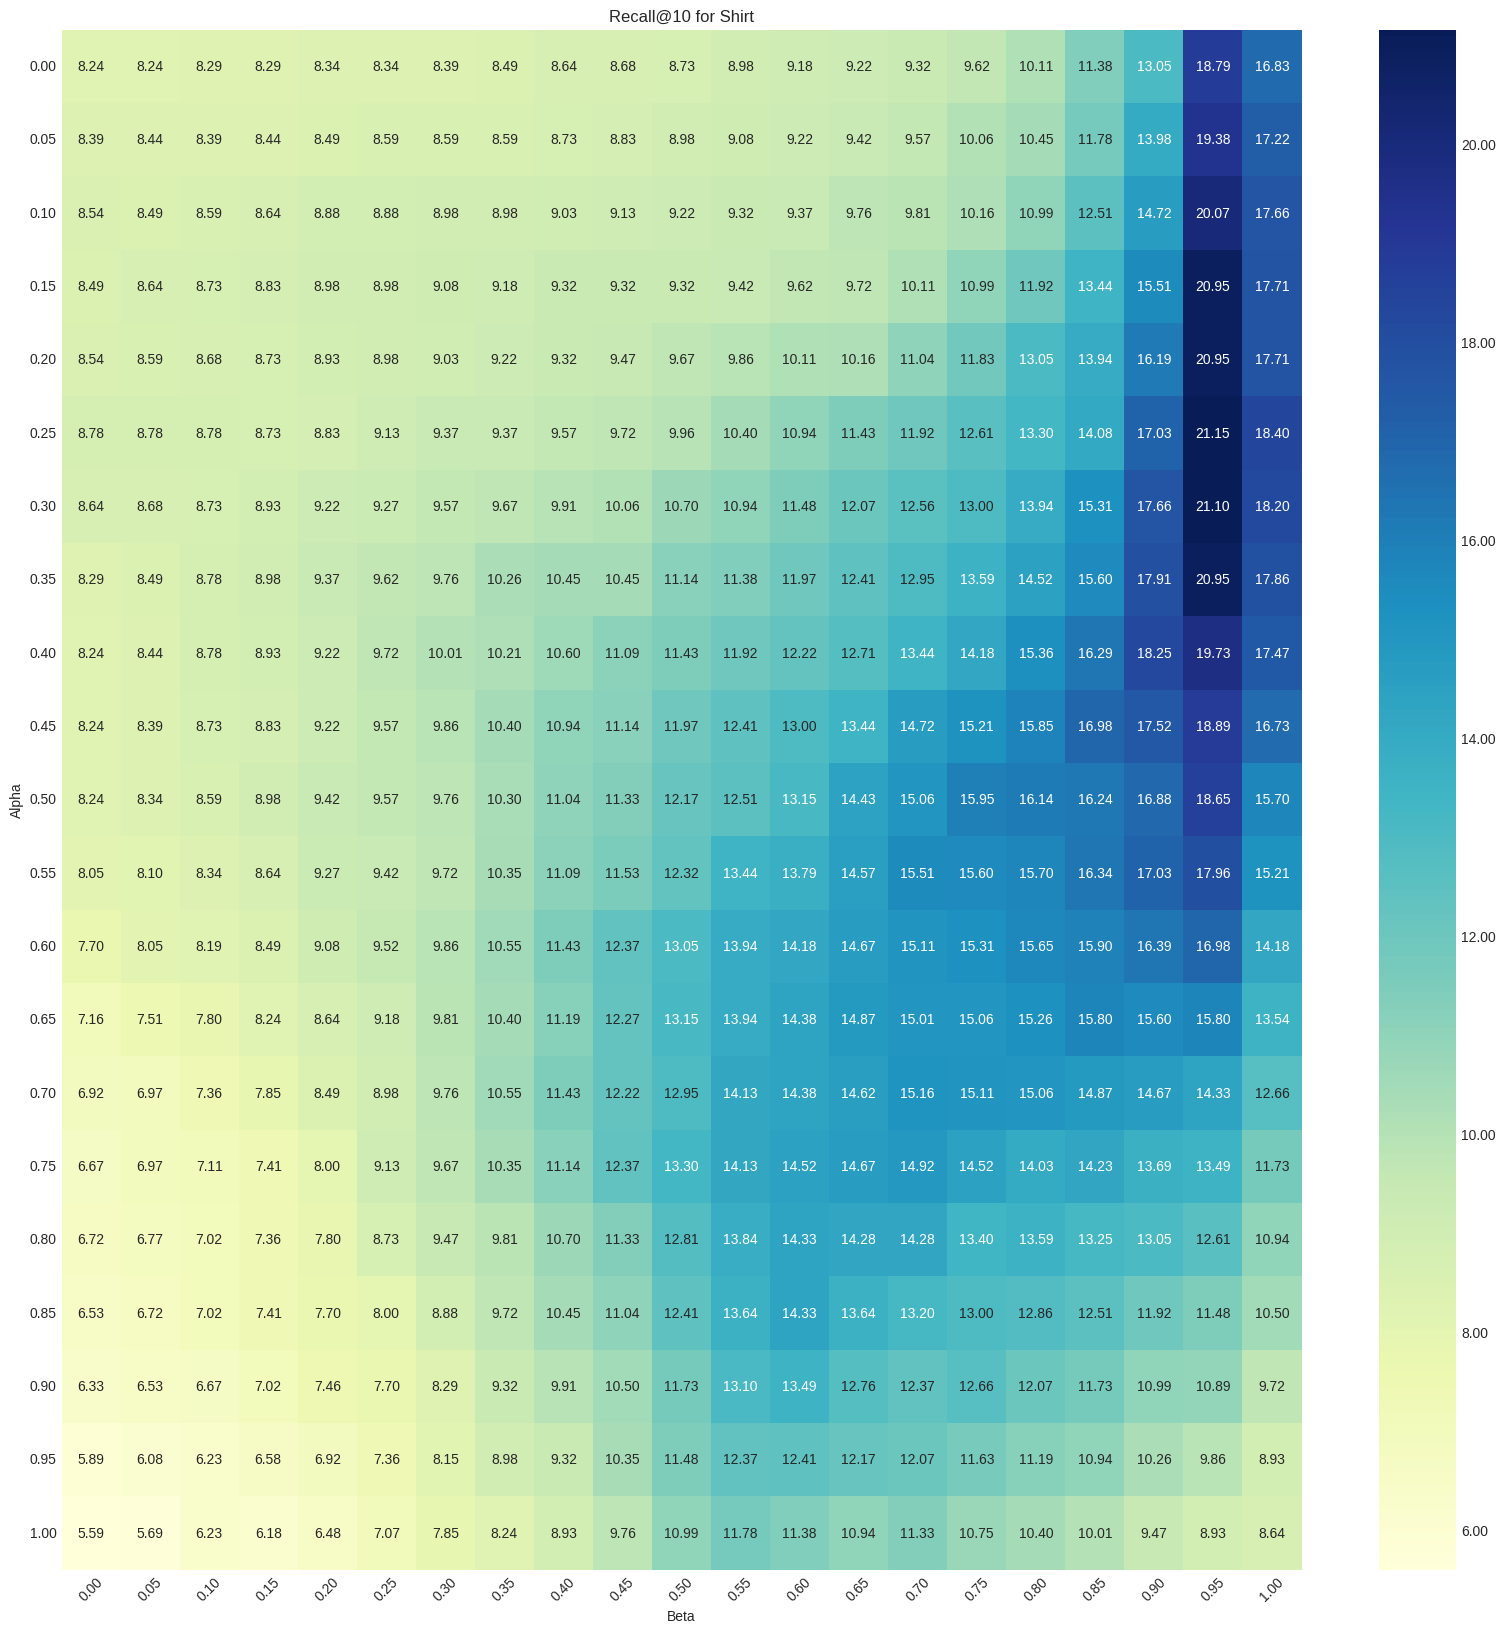

In [31]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

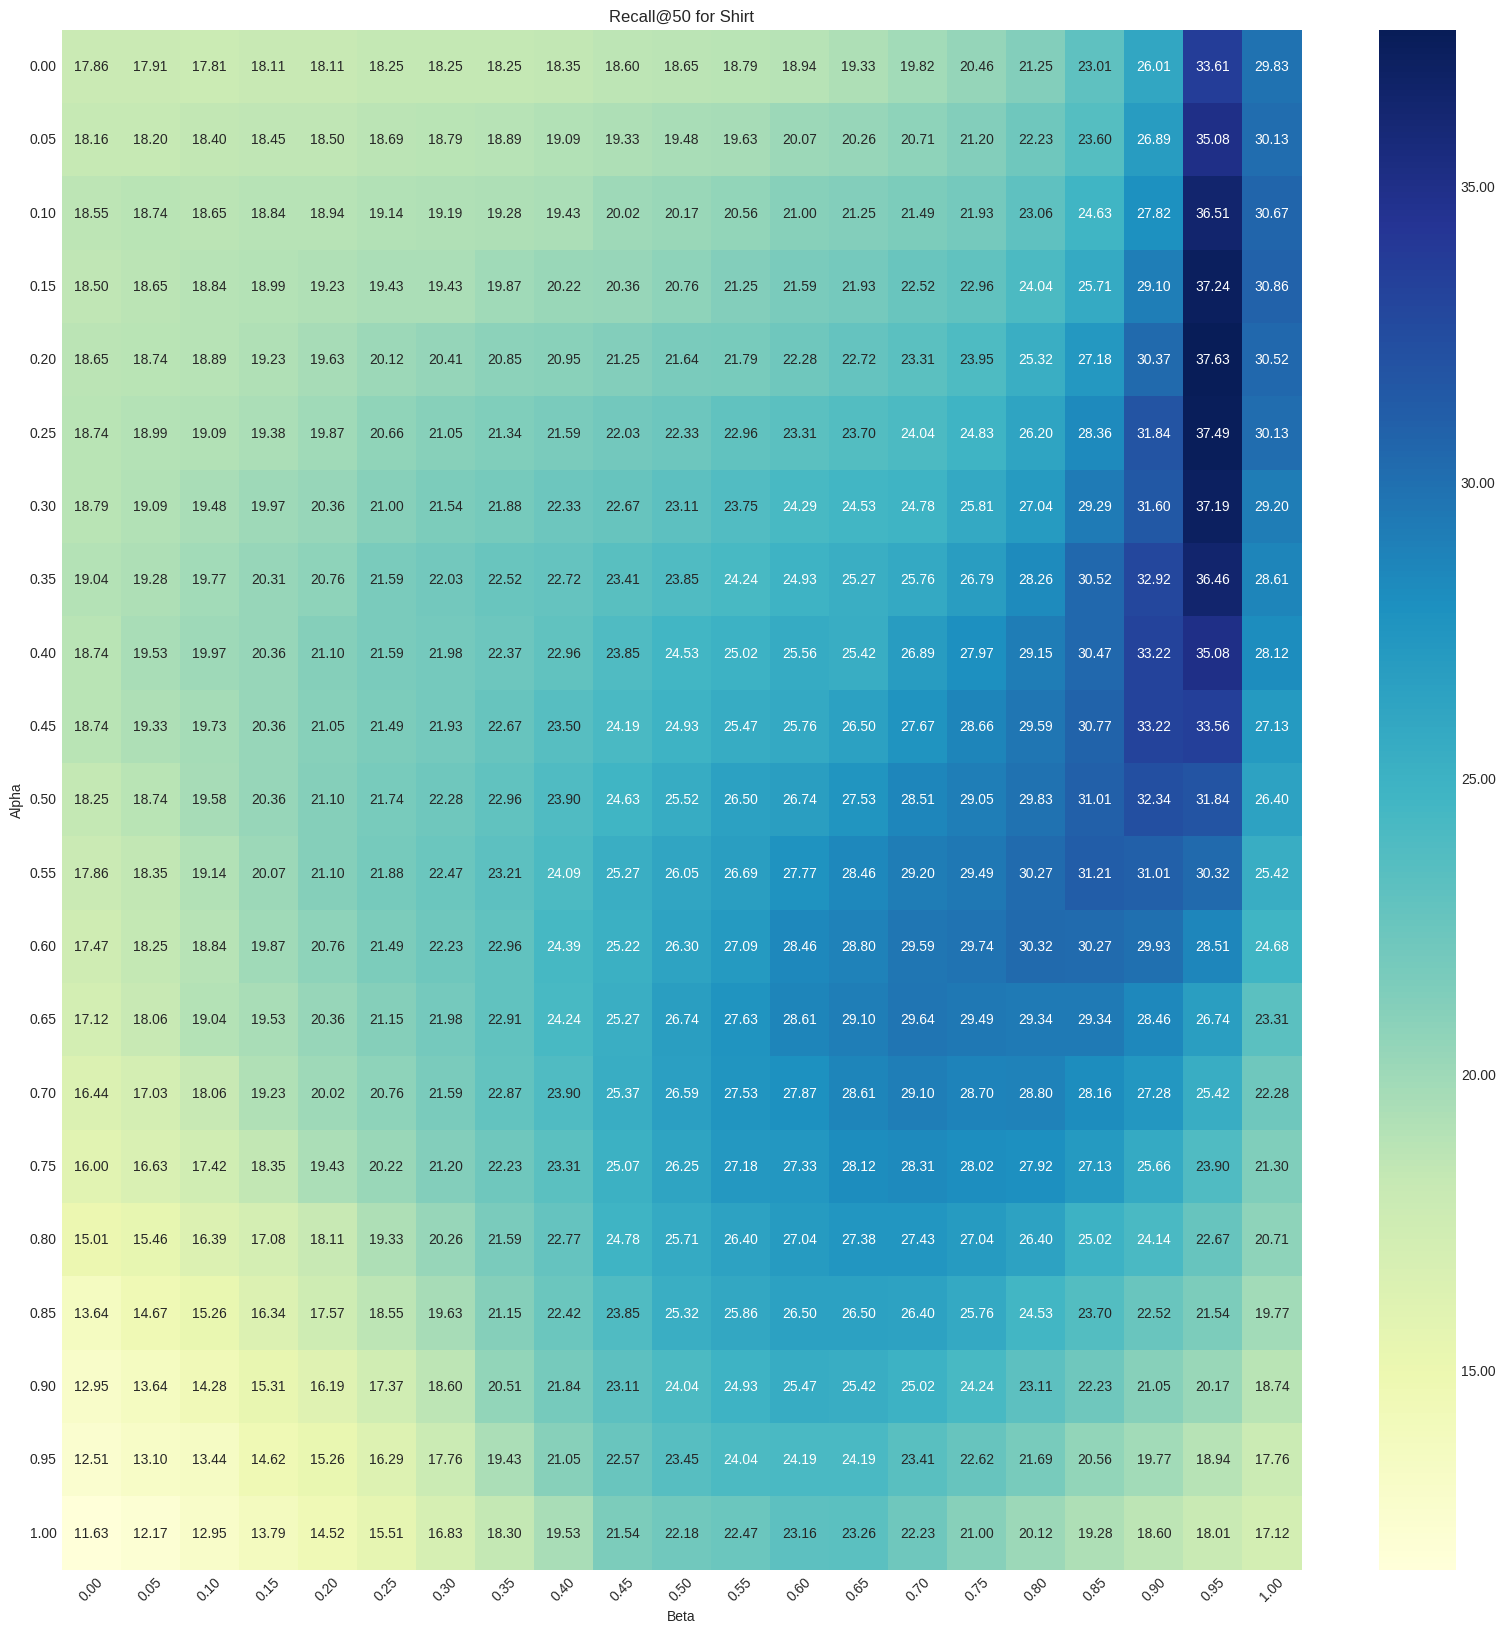

In [32]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

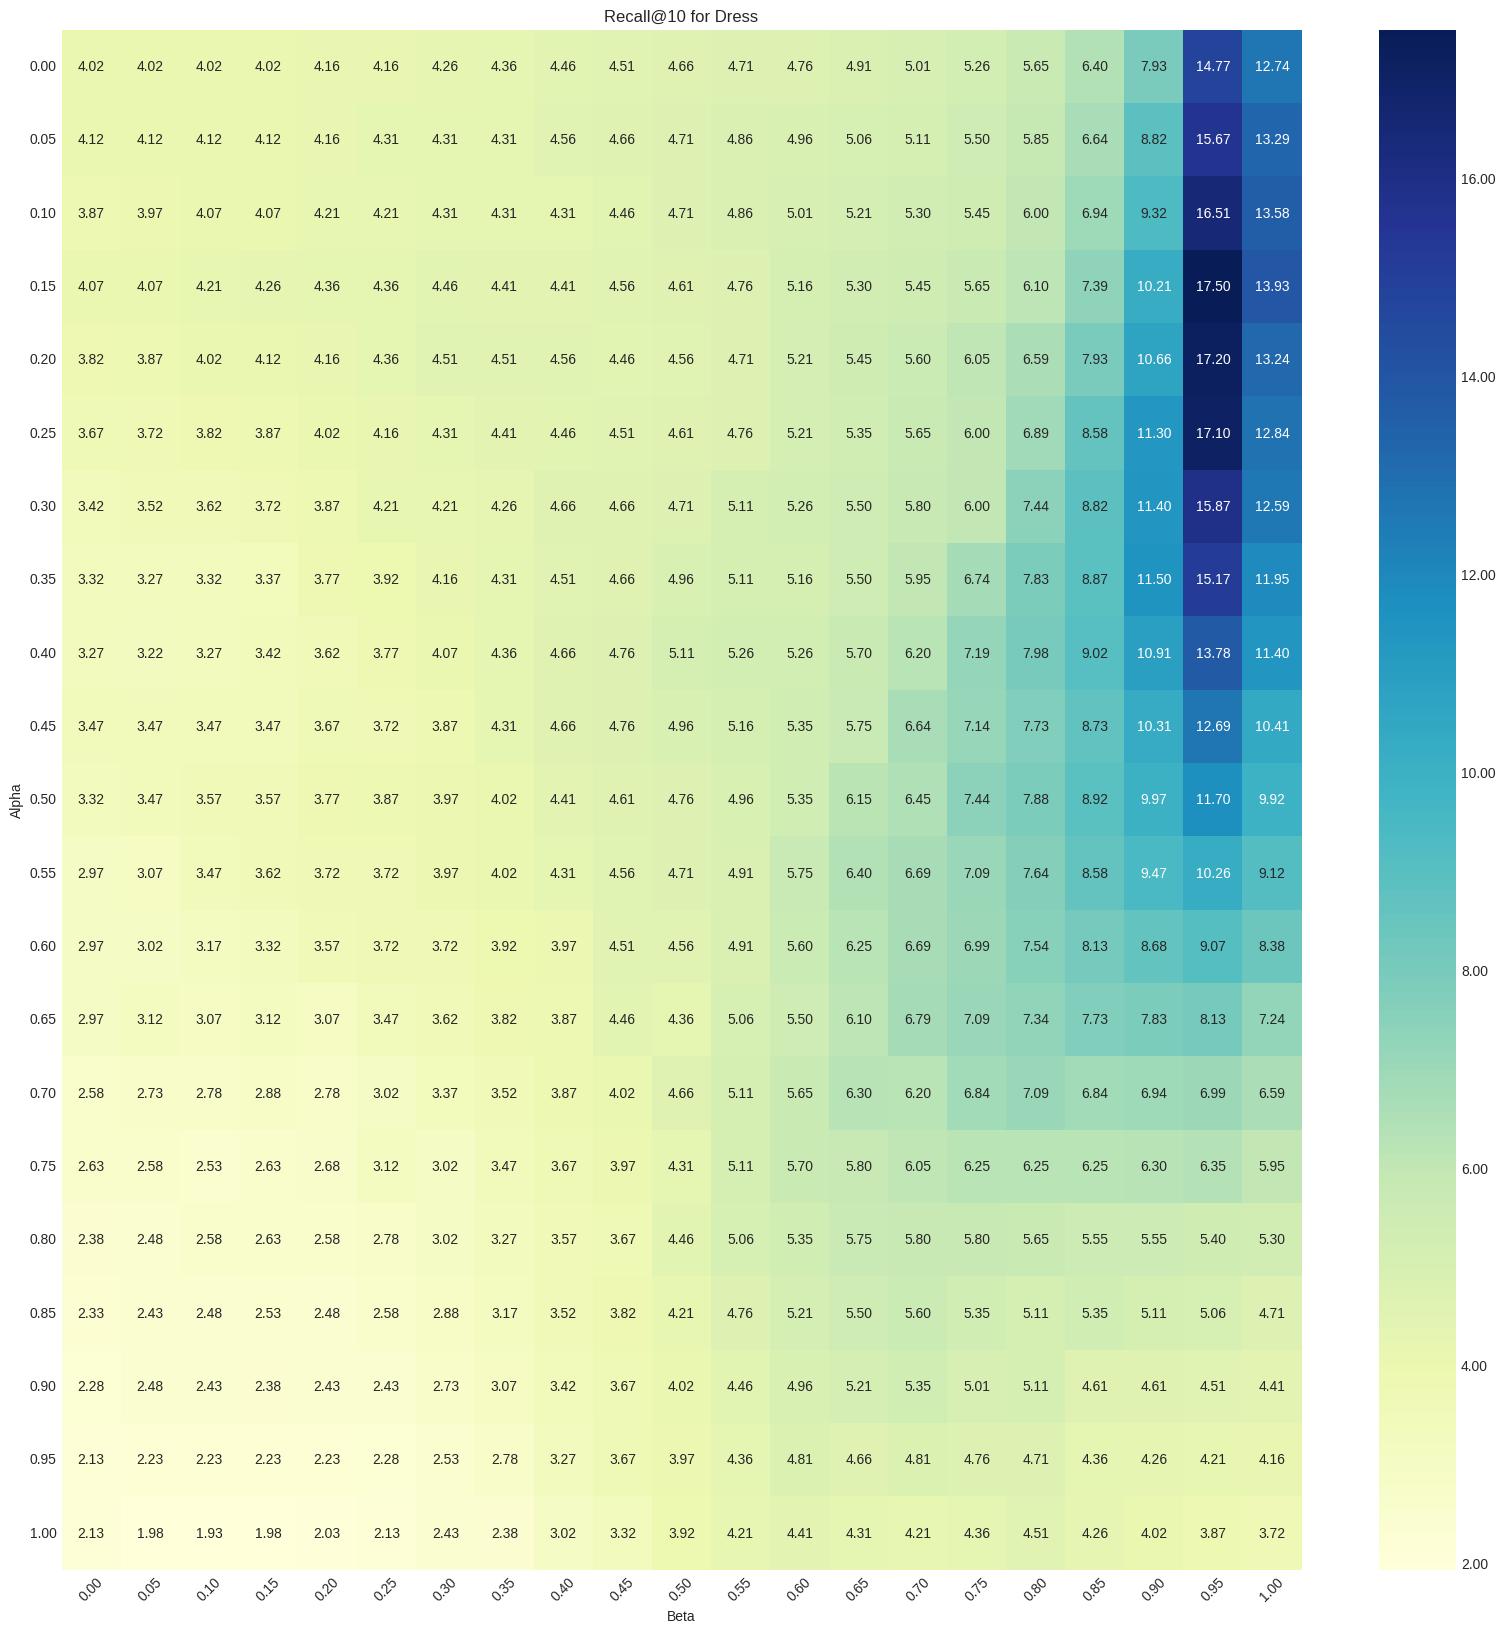

In [33]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

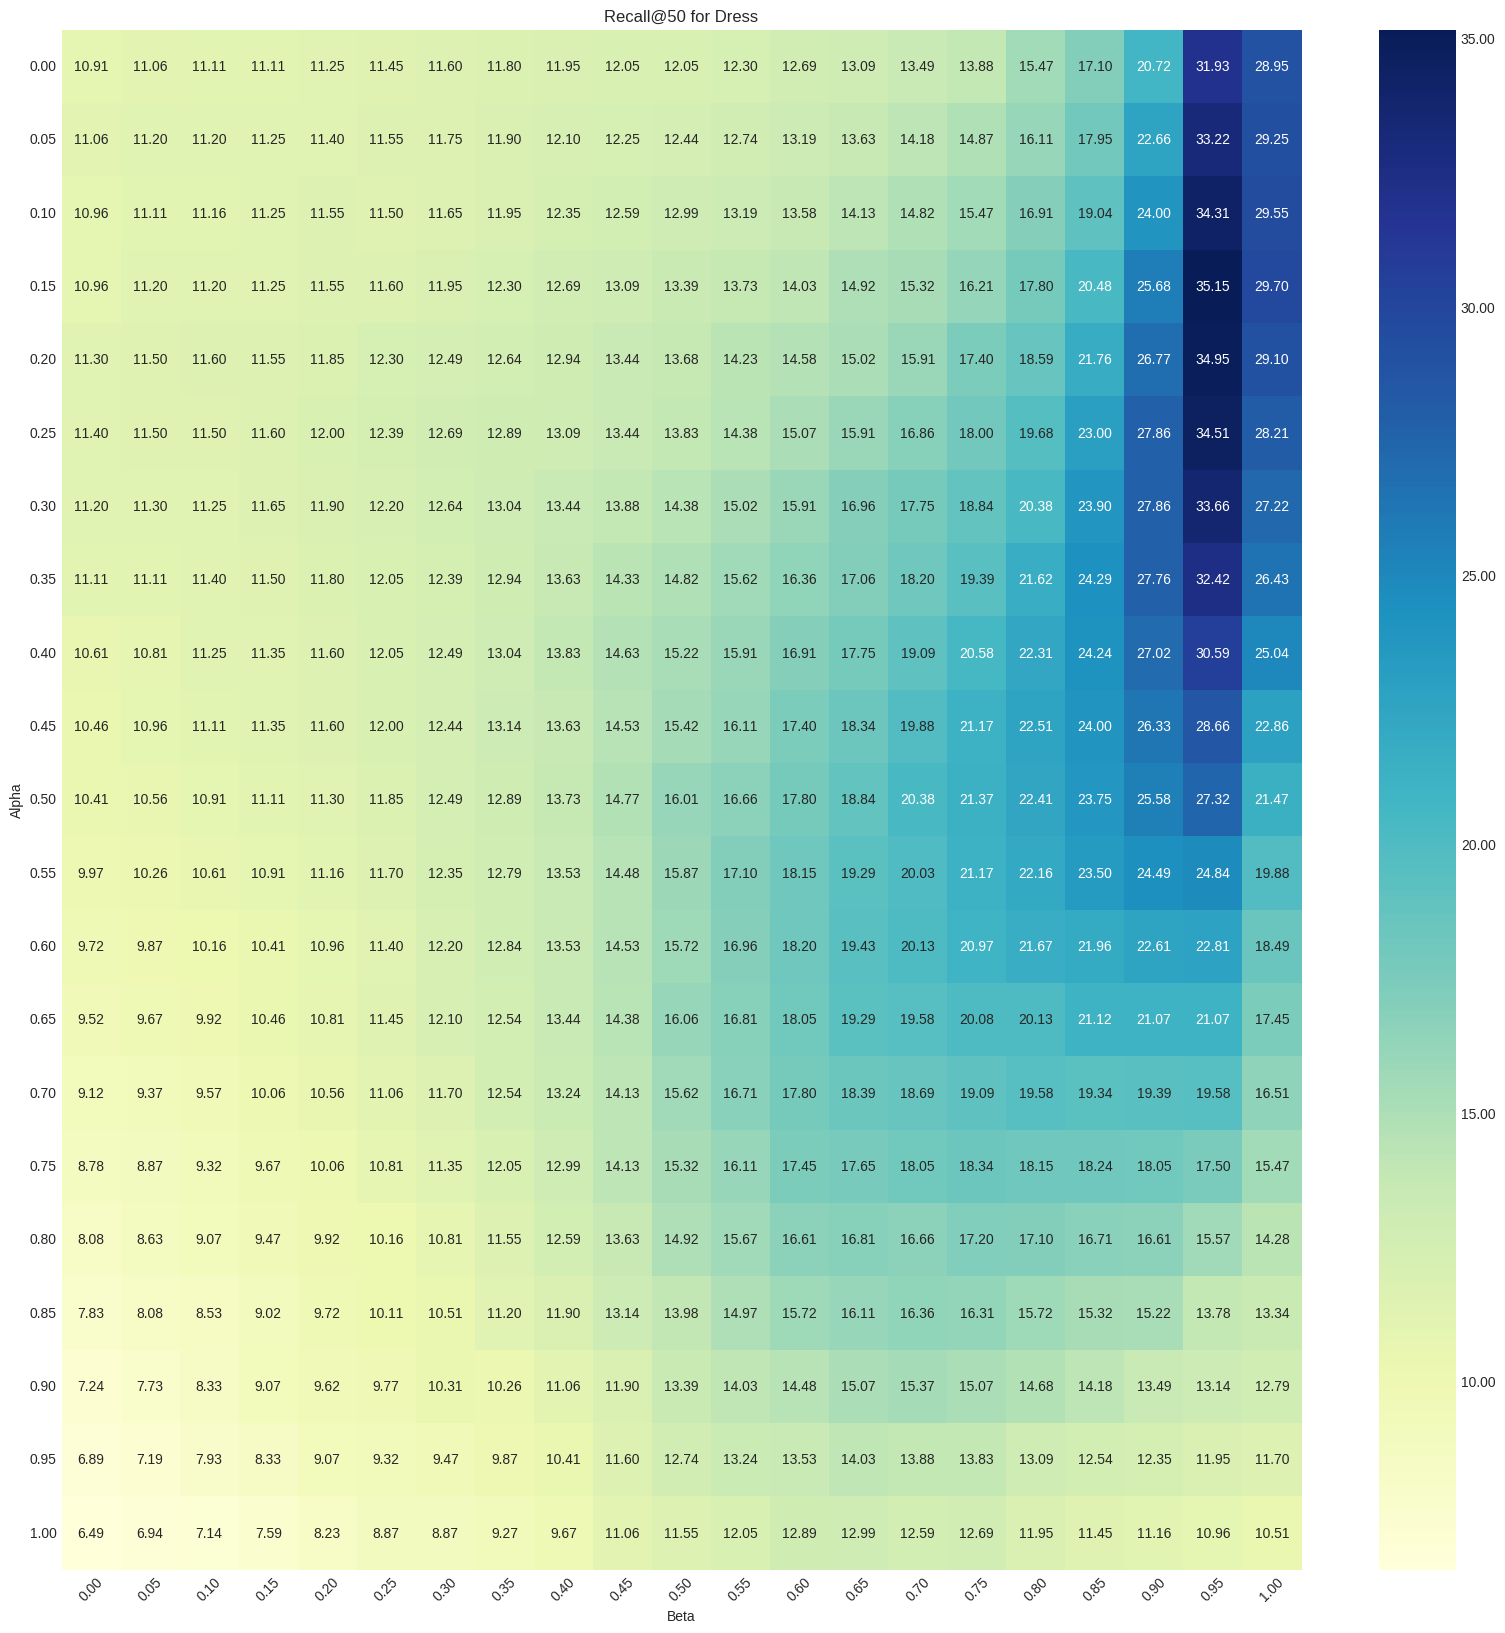

In [34]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

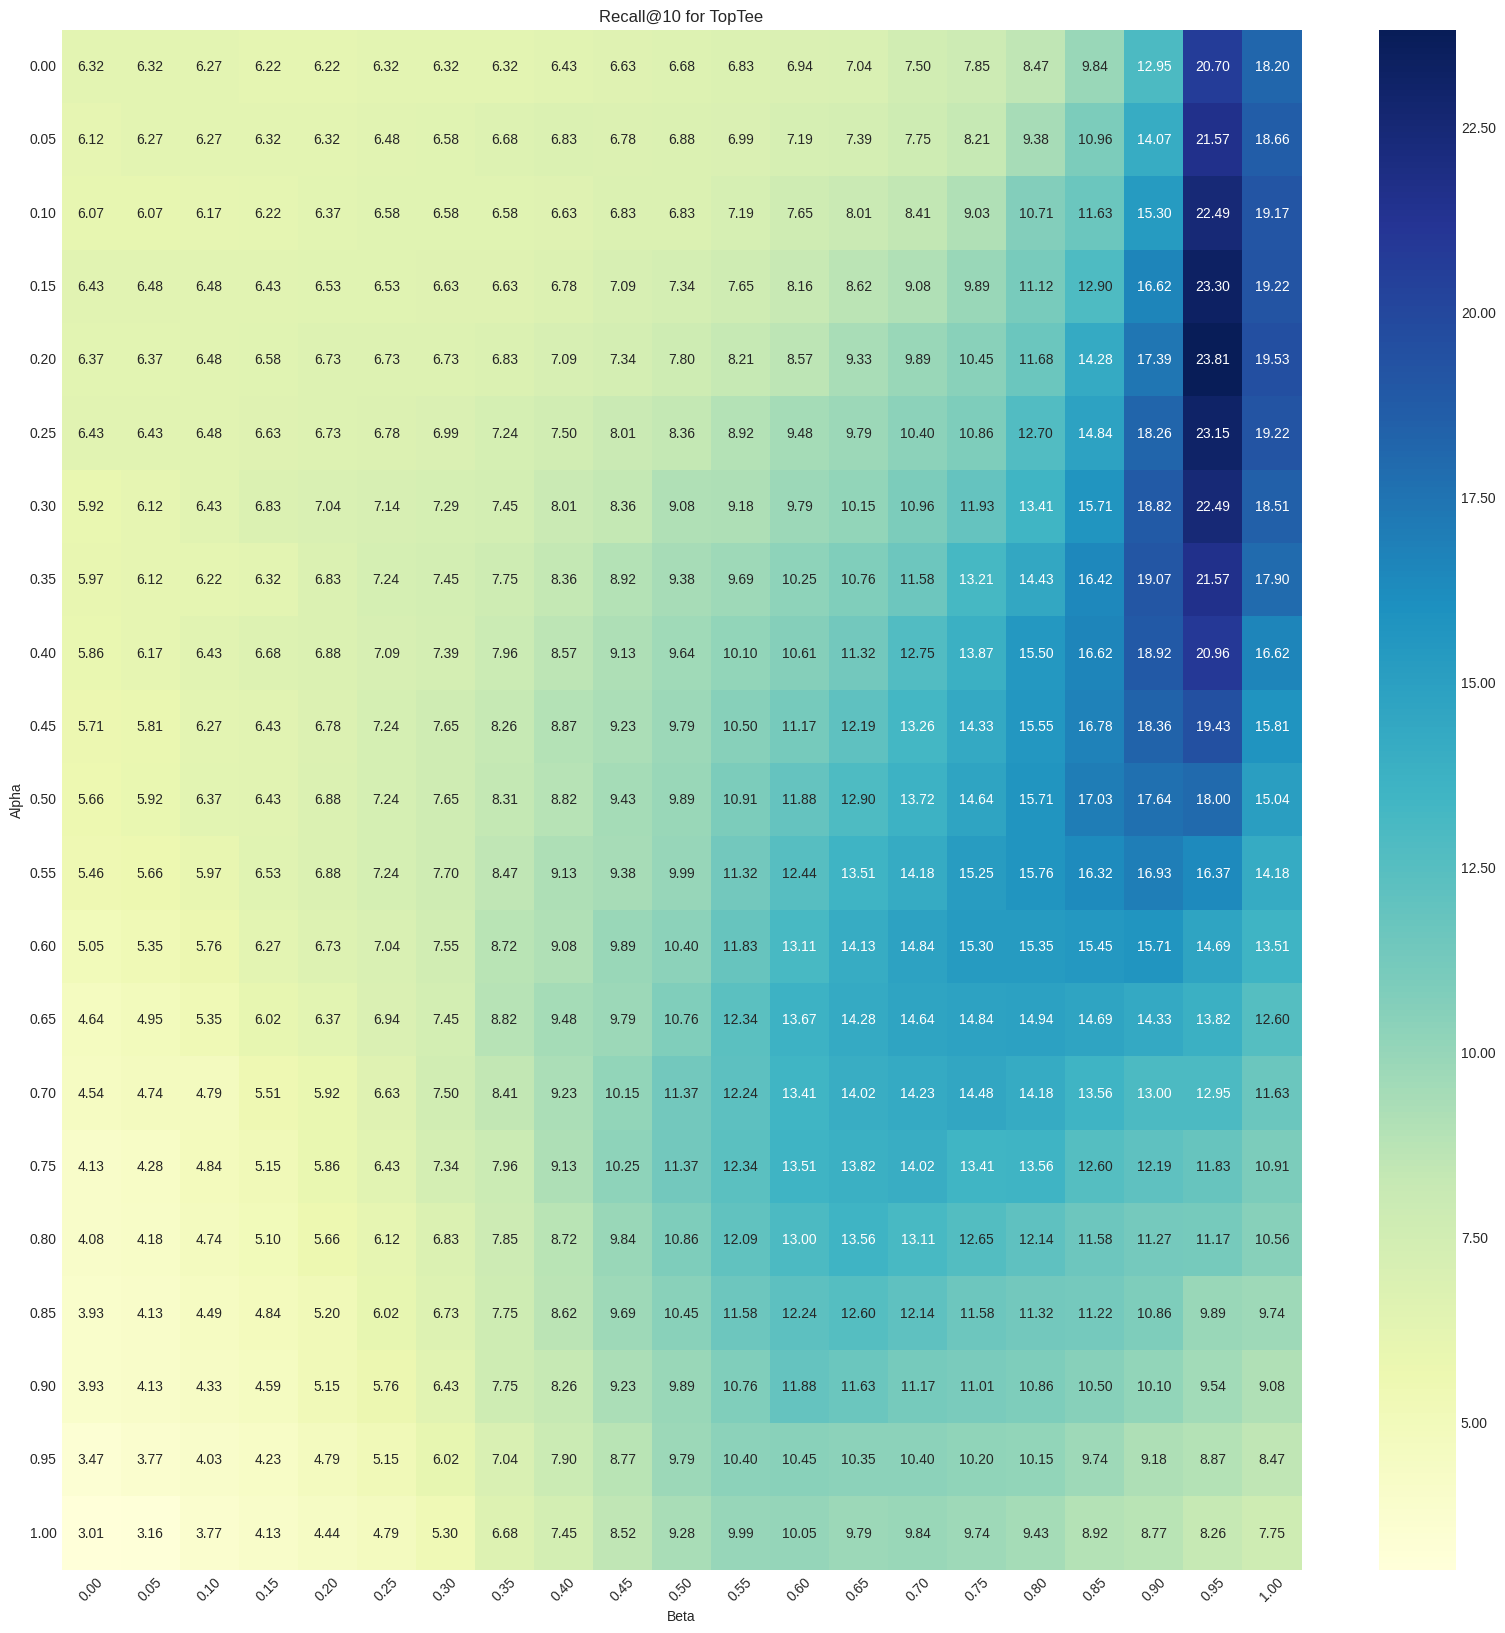

In [35]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

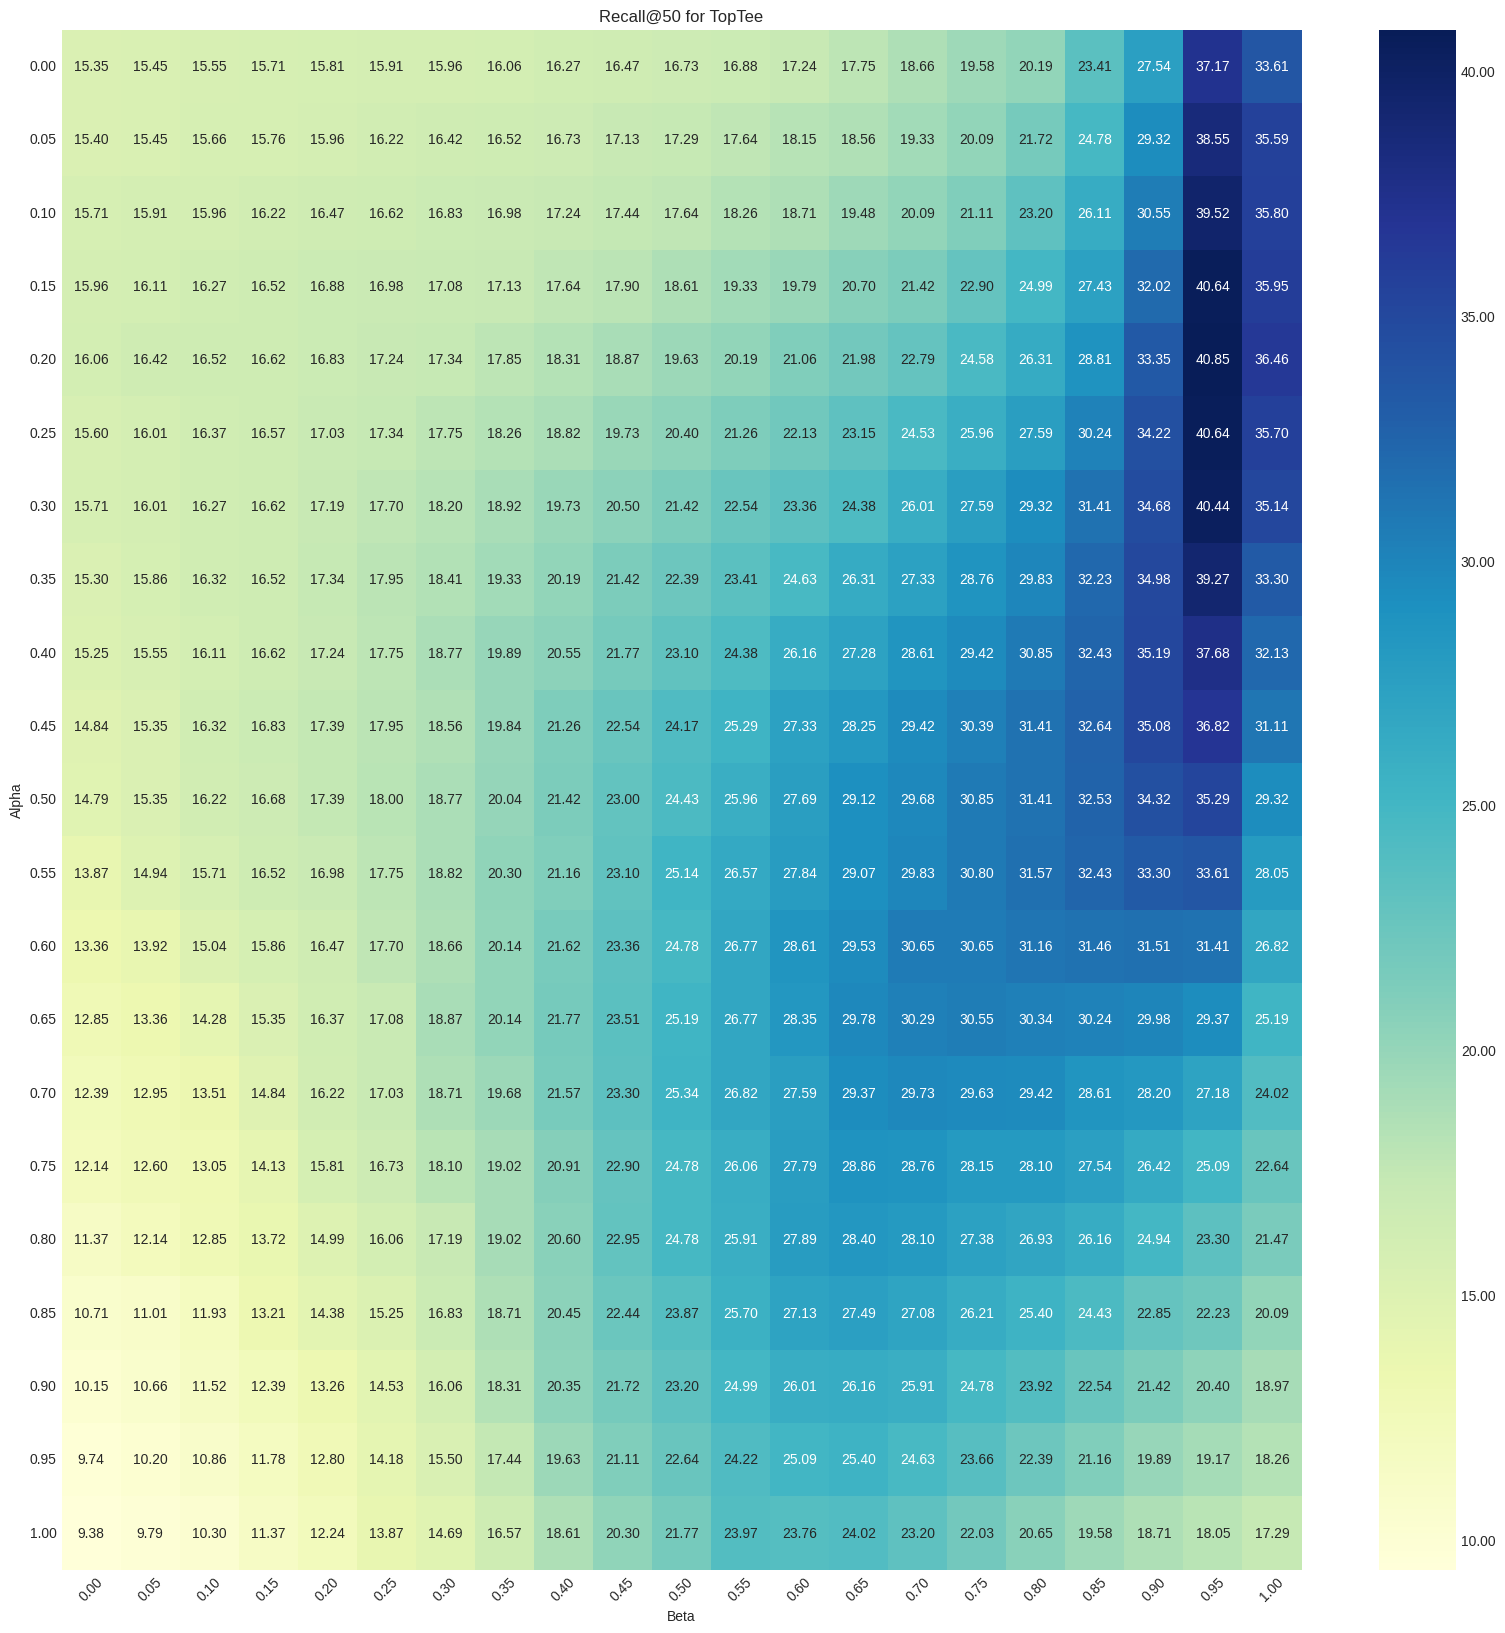

In [36]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

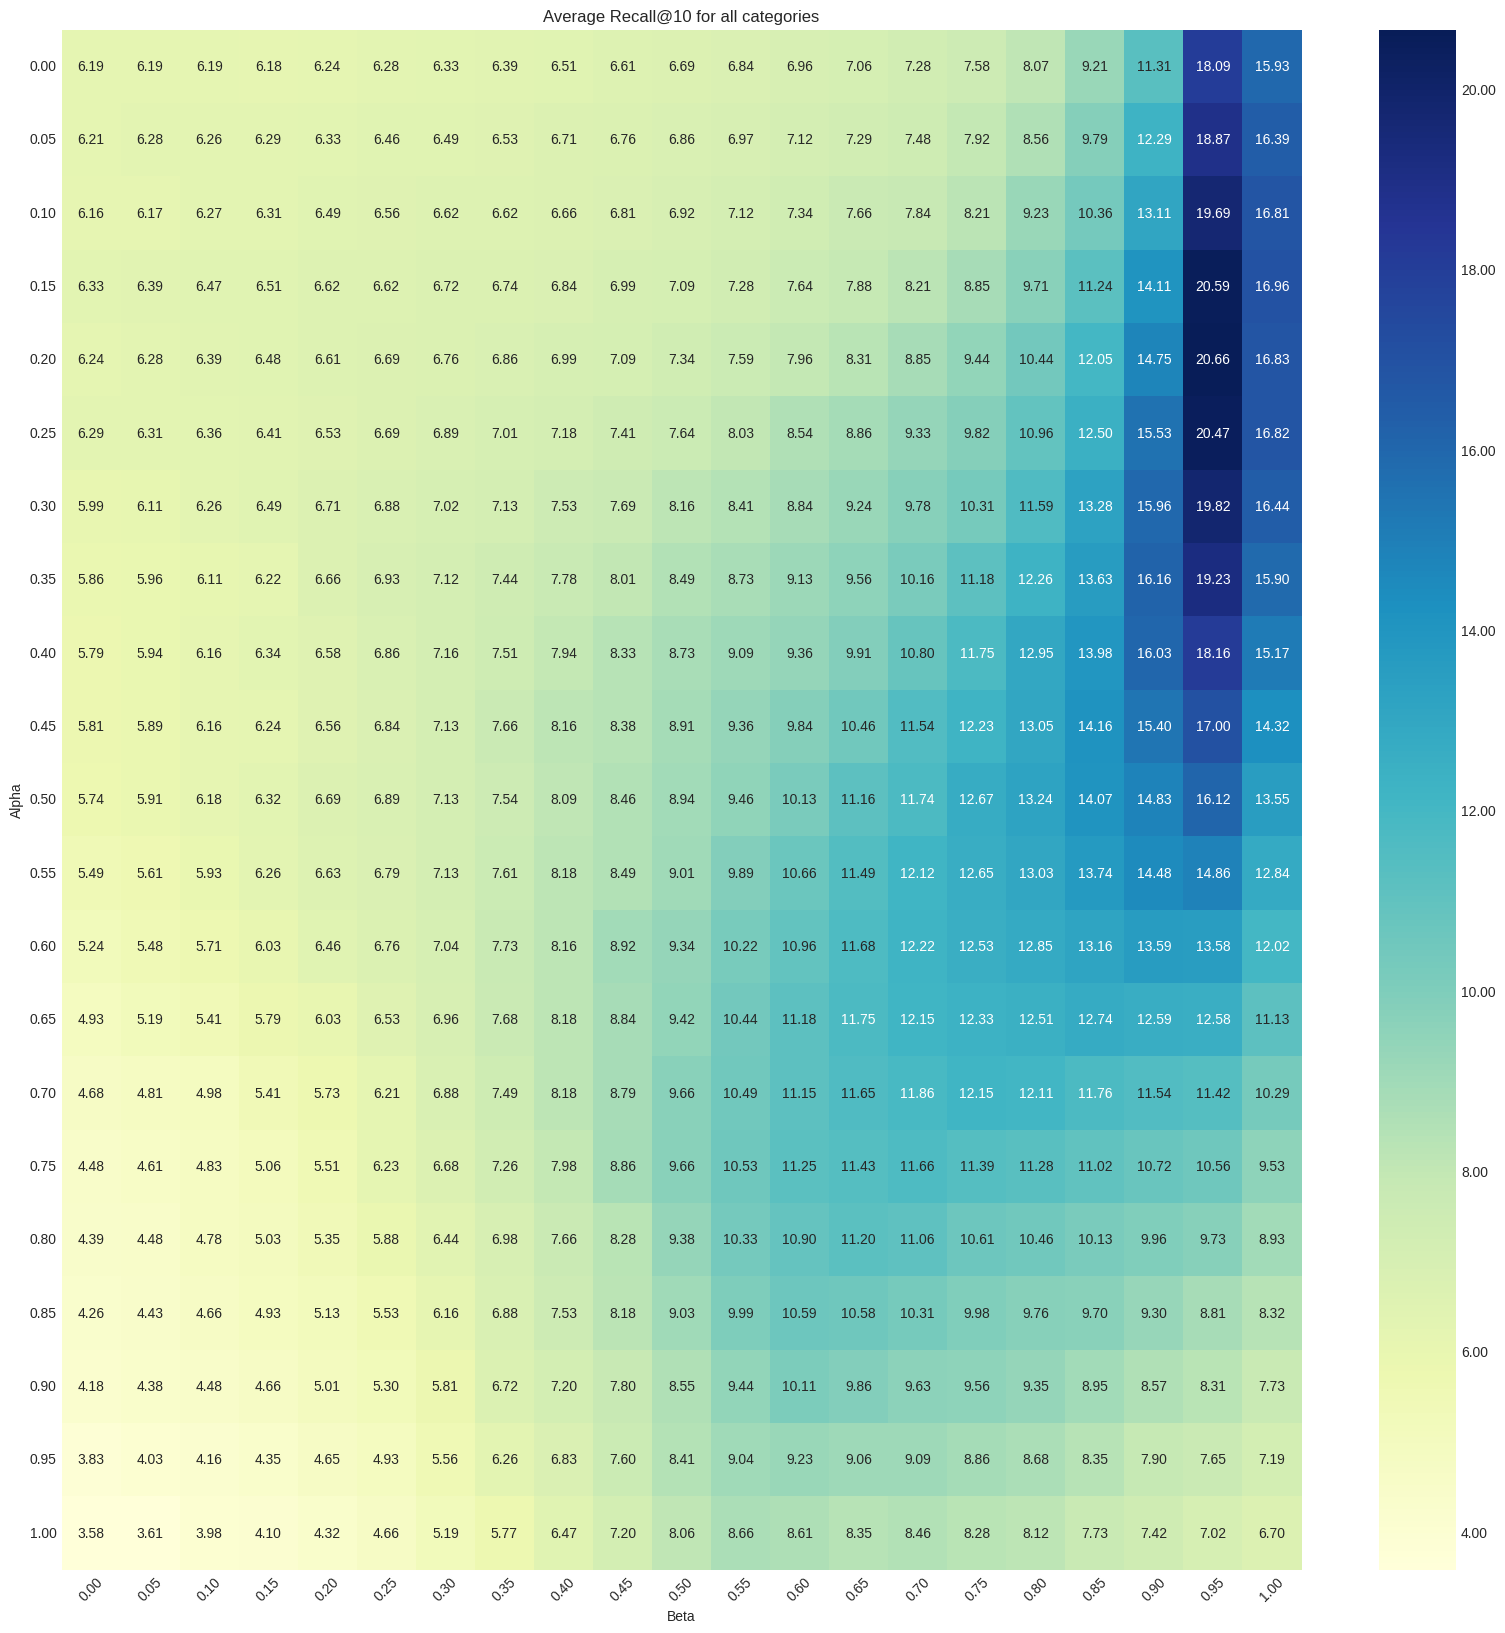

In [37]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

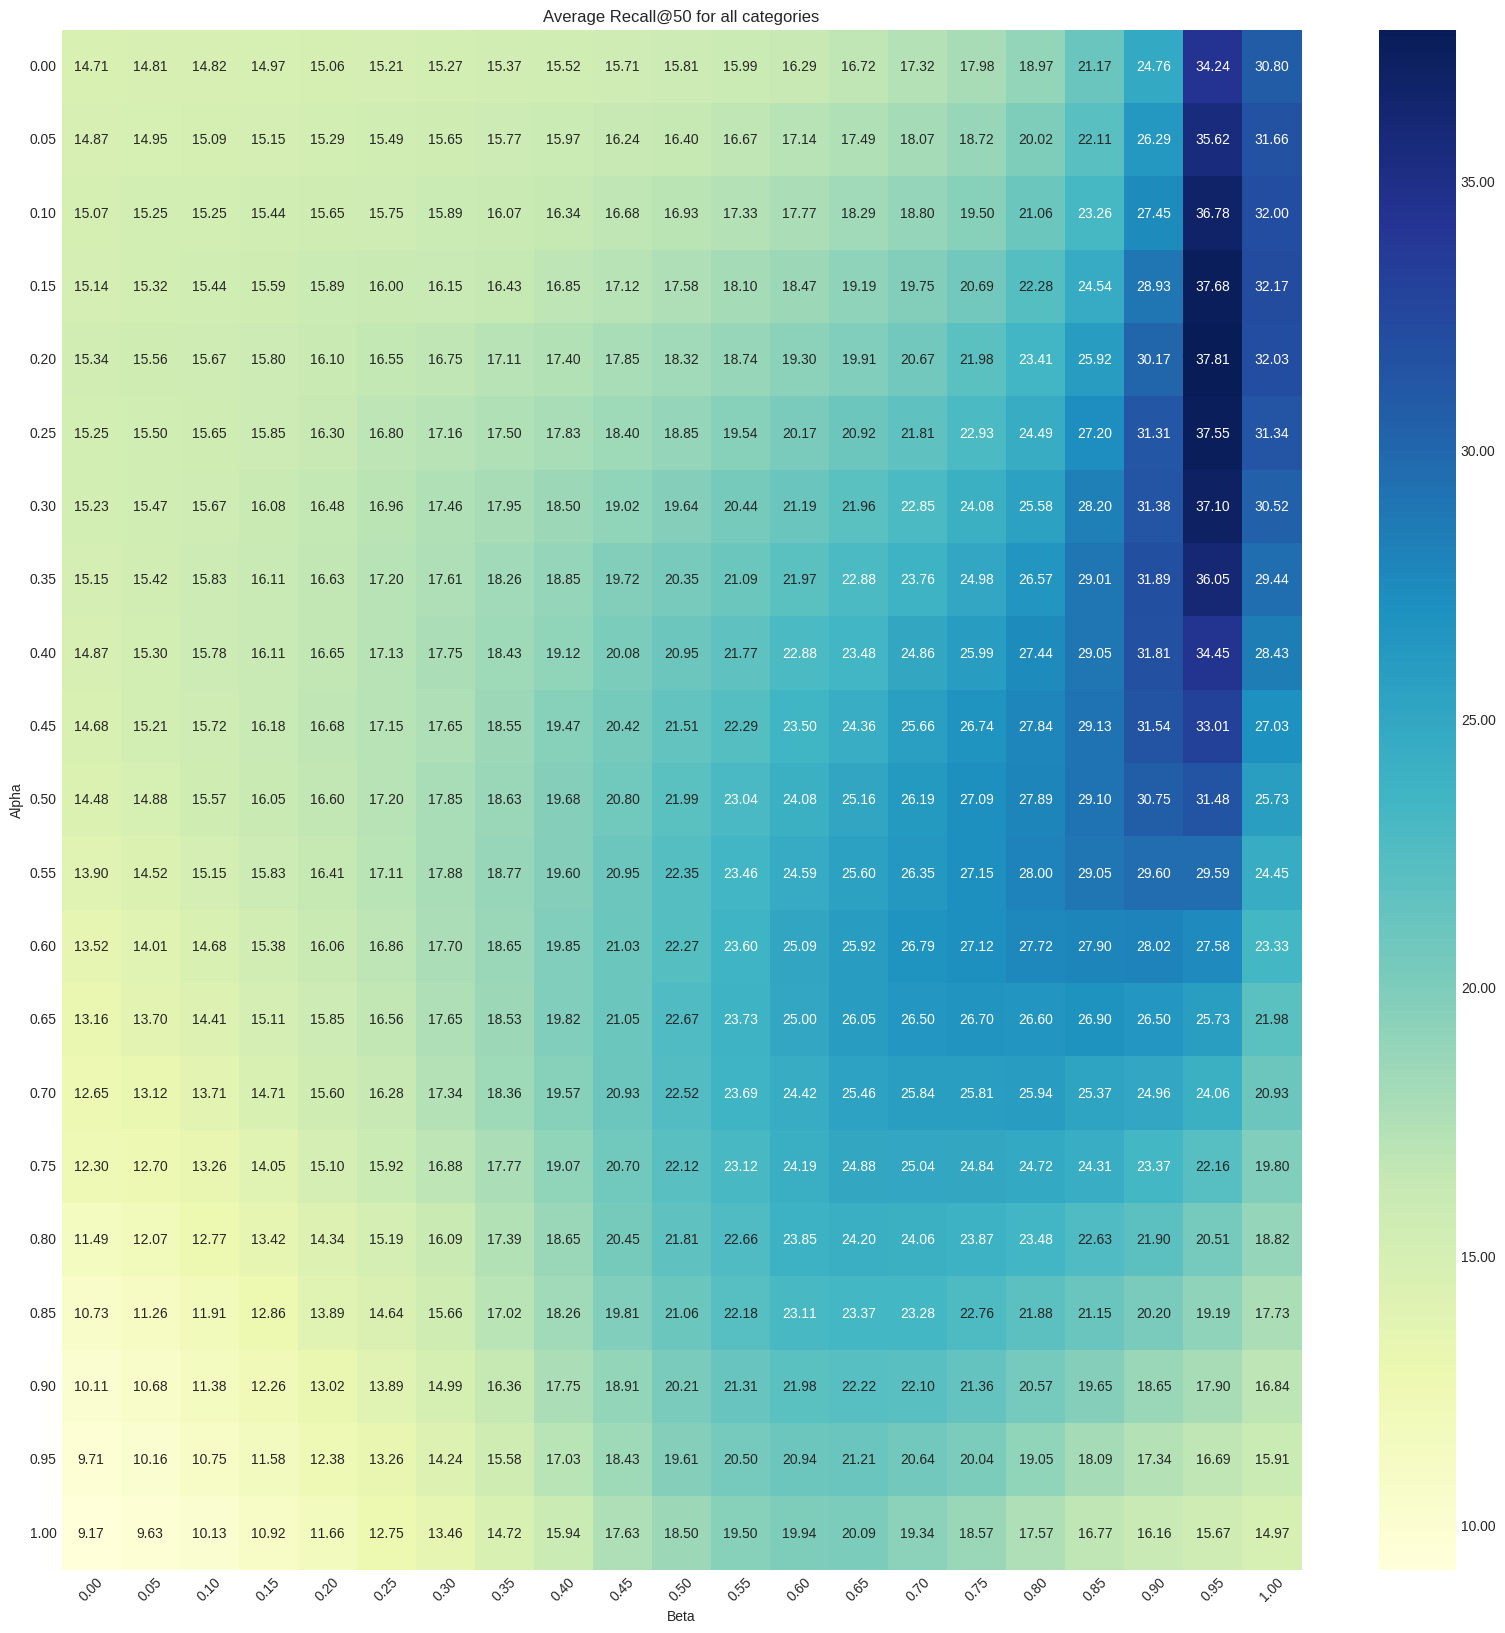

In [38]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the function to compute the results</div>

In [39]:
def compute_results(
    dress_type: str,
    combining_function: callable,
    blip_text_encoder: torch.nn.Module,
    blip_img_encoder: torch.nn.Module,
    text_captions: List[dict],
    preprocess: callable,
    alpha: float = 0.65
) -> Tuple[torch.tensor, List[str], List[str]]:
    """
    View sample results on FashionIQ dataset combining text and image distances.
    
    :param dress_type: FashionIQ category on which perform the retrieval
    :param combining_function:function which takes as input (image_features, text_features) and outputs the combined features
    :param blip_text_encoder: BLIP text model
    :param blip_img_encoder: BLIP image model
    :param text_captions: text captions for the FashionIQ dataset
    :param preprocess: preprocess pipeline
    :param alpha: alpha value for combining text and image distances
    
    :return: [(image_path, text_caption, candidate_image_paths)]
    """
    global cache
    cache_key = f"{dress_type}_cache"
    blip_text_encoder = blip_text_encoder.float().eval()
    blip_img_encoder = blip_img_encoder.float().eval()

    if cache_key not in cache:
        # Define the validation datasets and extract the index features
        classic_val_dataset = FashionIQDataset('val', [dress_type], 'classic', preprocess)

        multiple_index_features, multiple_index_names = [], []

        for i in range(3):
            index_features, index_names, _ = extract_index_features_with_text_captions(
                classic_val_dataset,
                blip_text_encoder,
                text_captions,
                i + 1
            )
            multiple_index_features.append(index_features)
            multiple_index_names.append(index_names)

        image_index_features, image_index_names = extract_index_features(classic_val_dataset, blip_img_encoder)

        cache[cache_key] = {
            "multiple_index_features": multiple_index_features,
            "multiple_index_names": multiple_index_names,
            "image_index_features": image_index_features,
            "image_index_names": image_index_names
        }
    else:
        multiple_index_features = cache[cache_key]["multiple_index_features"]
        multiple_index_names = cache[cache_key]["multiple_index_names"]
        image_index_features = cache[cache_key]["image_index_features"]
        image_index_names = cache[cache_key]["image_index_names"]

    relative_val_dataset = FashionIQDataset('val', [dress_type], 'relative', preprocess)

    all_text_distances = []

    # Compute distances for individual text features
    for text_features, text_names in zip(multiple_index_features, multiple_index_names):
        # Generate text predictions and normalize features
        predicted_text_features, target_names = generate_fiq_val_predictions(
            blip_text_encoder, relative_val_dataset,
            combining_function, text_names,
            text_features)
        # Normalize features
        text_features = F.normalize(text_features, dim=-1)
        predicted_text_features = F.normalize(predicted_text_features, dim=-1)

        # Compute cosine similarity and convert to distance
        cosine_similarities = torch.mm(predicted_text_features, text_features.T)
        distances = 1 - cosine_similarities
        all_text_distances.append(distances)

    predicted_image_features, target_names = generate_fiq_val_predictions(
        blip_text_encoder, relative_val_dataset,
        combining_function, image_index_names,
        image_index_features)

    # Normalize and compute distances
    image_index_features = F.normalize(image_index_features, dim=-1).float()
    image_distances = 1 - predicted_image_features @ image_index_features.T

    # Merge text distances
    merged_text_distances = torch.mean(torch.stack(all_text_distances), dim=0)

    merged_distances = alpha * merged_text_distances + (1 - alpha) * image_distances

    sorted_indices = torch.argsort(merged_distances, dim=-1).cpu()
    sorted_index_names = np.array(image_index_names if image_index_names else multiple_index_names[0])[sorted_indices]
    labels = torch.tensor(
        sorted_index_names == np.repeat(np.array(target_names),
                                        len(image_index_names if image_index_names else multiple_index_names[
                                            0])).reshape(len(target_names), -1))
    assert torch.equal(torch.sum(labels, dim=-1).int(), torch.ones(len(target_names)).int())
    recall_at10 = (torch.sum(labels[:, :10]) / len(labels)).item() * 100
    recall_at50 = (torch.sum(labels[:, :50]) / len(labels)).item() * 100

    print(f"Recall at 10: {recall_at10}")
    print(f"Recall at 50: {recall_at50}")

    return sorted_indices, image_index_names, target_names

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [40]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results(
    'dress',
    get_combing_function_with_beta(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0.2
)

FashionIQ val - ['dress'] dataset in relative mode initialized


100%|██████████| 64/64 [00:01<00:00, 56.35it/s]


Recall at 10: 17.203767597675323

Recall at 50: 34.95289981365204

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [41]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results(
    'shirt',
    get_combing_function_with_beta(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0.2
)

FashionIQ val - ['shirt'] dataset in relative mode initialized


100%|██████████| 64/64 [00:01<00:00, 57.62it/s]


Recall at 10: 20.95191329717636

Recall at 50: 37.63493597507477

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [42]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results(
    'toptee',
    get_combing_function_with_beta(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0.2
)

FashionIQ val - ['toptee'] dataset in relative mode initialized


100%|██████████| 62/62 [00:01<00:00, 57.10it/s]


Recall at 10: 23.814380168914795

Recall at 50: 40.846505761146545

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [43]:
def prepare_ground_truths(json_data):
    """
    Prepare ground truth data from the JSON structure.
    
    :param json_data: JSON data containing target and candidate matches with captions
    :return: Dictionary mapping targets to lists of tuples (candidates and captions)
    """
    ground_truths = {}
    for entry in json_data:
        target = entry['target']
        candidate = entry['candidate']
        captions = entry['captions']
        if target not in ground_truths:
            ground_truths[target] = []
        ground_truths[target].append((candidate, captions))  # Store as a tuple
    return ground_truths

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the retrieval results for a query</div>

In [44]:
def plot_retrieval_results_of_i(sorted_indices, image_index_names, target_names, ground_truths, top_k=5, i=0):
    """
    Plot retrieval results for a specific query showing the query and its top retrieved images, highlighting ground truths
    and displaying associated captions to the left of the query image.

    :param sorted_indices: 2D tensor or array with sorted indices of retrieved images per query.
    :param image_index_names: List of image paths corresponding to indices in sorted_indices.
    :param target_names: List of names or descriptions for each query.
    :param ground_truths: Dictionary mapping target names to lists of tuples (candidates and captions).
    :param top_k: Number of top retrieved results to display per query.
    :param i: Index of the query to display.
    """
    query_index = i
    retrival_result_images = [image_index_names[j] for j in sorted_indices[query_index]][:top_k]
    ground_truth_target = target_names[query_index]
    query_img_path, query_captions = ground_truths.get(ground_truth_target, [('', '')])[0]

    fig = plt.figure(figsize=(30, 5))
    gs = GridSpec(1, top_k + 2, figure=fig)
    query_img = Image.open(f'../fashionIQ_dataset/images/{query_img_path}.png')

    # Subplot for the caption text to the left of the query image
    ax_text = fig.add_subplot(gs[0, 0])
    query_name = query_img_path
    query_captions = '\n'.join(sentences for sentences in query_captions)
    ax_text.text(0.5, 0.5, query_captions, va='center', ha='center')
    ax_text.axis('off')

    # Subplot for the query image
    ax_image = fig.add_subplot(gs[0, 1])
    ax_image.imshow(query_img)
    ax_image.set_title(f"Query: {query_name}", color='blue')
    ax_image.axis('off')

    for j, img_path in enumerate(retrival_result_images):
        img = Image.open(f'../fashionIQ_dataset/images/{img_path}.png')

        ax_result = fig.add_subplot(gs[0, j + 2])
        ax_result.imshow(img)

        # Check if this image is a ground truth and retrieve its captions
        if img_path == ground_truth_target:
            ax_result.set_title(f"{img_path}", color='green')
        else:
            ax_result.set_title(img_path)

        ax_result.axis('off')

    plt.tight_layout()
    plt.show()

In [45]:
ground_truth_dress = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.toptee.val.json')))

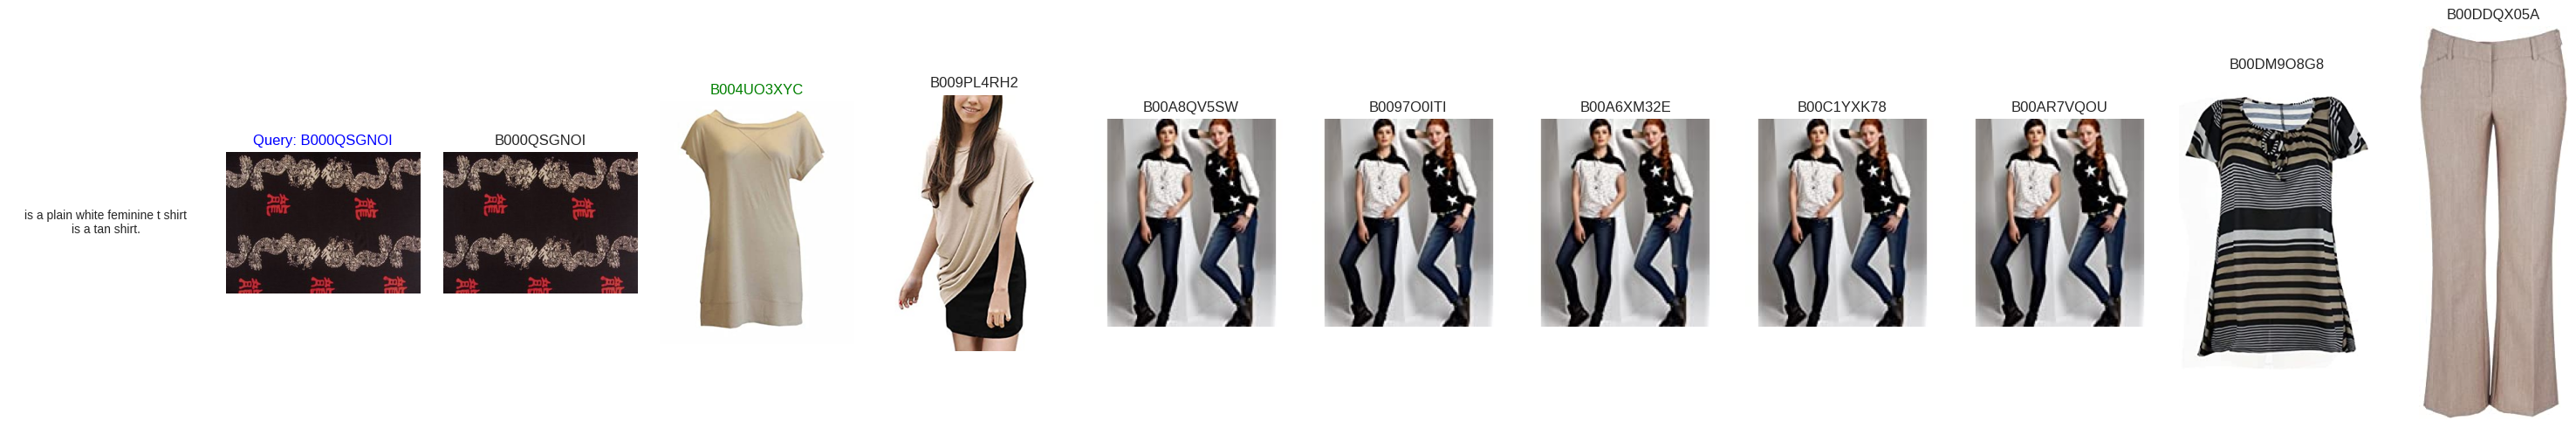

In [46]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=3)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with alpha=0 (Same as the original BLIP4CIR)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category with alpha=0</div>

In [47]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results(
    'dress',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['dress'] dataset in relative mode initialized


100%|██████████| 64/64 [00:01<00:00, 55.81it/s]


Recall at 10: 4.6603865921497345

Recall at 50: 12.047595530748367

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category with alpha=0</div>

In [48]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results(
    'shirt',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['shirt'] dataset in relative mode initialized


100%|██████████| 64/64 [00:01<00:00, 57.48it/s]


Recall at 10: 8.734052628278732

Recall at 50: 18.64573061466217

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category with alpha=0</div>

In [49]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results(
    'toptee',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['toptee'] dataset in relative mode initialized


100%|██████████| 62/62 [00:01<00:00, 56.07it/s]


Recall at 10: 6.6802650690078735

Recall at 50: 16.726160049438477

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results</div>

In [50]:
def found_better_than_original(
        sorted_indices_origin, image_index_names_origin, target_names_origin,
        sorted_indices, image_index_names, target_names, top_k=10
) -> List[int]:
    """
    Return indices of queries where the new retrieval results are better than the original results based on the rank
    of the ground truth in the top_k results.

    Args:
        sorted_indices_origin (np.ndarray): 2D array of sorted indices by relevance per query for the original method.
        image_index_names_origin (List[str]): List of image names corresponding to indices in sorted_indices_origin.
        target_names_origin (List[str]): List of names or descriptions for each query for the original method.
        sorted_indices (np.ndarray): 2D array of sorted indices by relevance per query for the new method.
        image_index_names (List[str]): List of image names corresponding to indices in sorted_indices.
        target_names (List[str]): List of target names each query is supposed to retrieve.
        top_k (int): Number of top retrieved results to consider per query.

    Returns:
        List[int]: List of indices where the new method outperforms the original method in terms of the rank of the
        ground truth target.
    """
    better_indices = []
    total_queries = len(target_names)  # Assuming the same number of queries for both sets

    for index in range(total_queries):
        # Find the index of the ground truth in the top_k results of the original method
        new_rank = [image_index_names[i] for i in sorted_indices[index]].index(target_names[index])
        origin_rank = [image_index_names_origin[i] for i in sorted_indices_origin[index]].index(target_names_origin[index])

        if new_rank <= top_k < origin_rank:
            better_indices.append(index)

    return better_indices

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [51]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

(297, [1, 3, 12, 15, 16, 33, 34, 36, 40, 58])

In [52]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(30, [62, 109, 125, 215, 218, 593, 605, 624, 657, 684])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [53]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

(284, [1, 8, 11, 13, 19, 40, 44, 49, 55, 59])

In [54]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(32, [84, 133, 222, 263, 385, 394, 444, 457, 640, 754])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [55]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

(374, [2, 3, 7, 9, 10, 16, 21, 24, 28, 39])

In [56]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(37, [32, 142, 216, 230, 241, 369, 523, 635, 677, 732])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

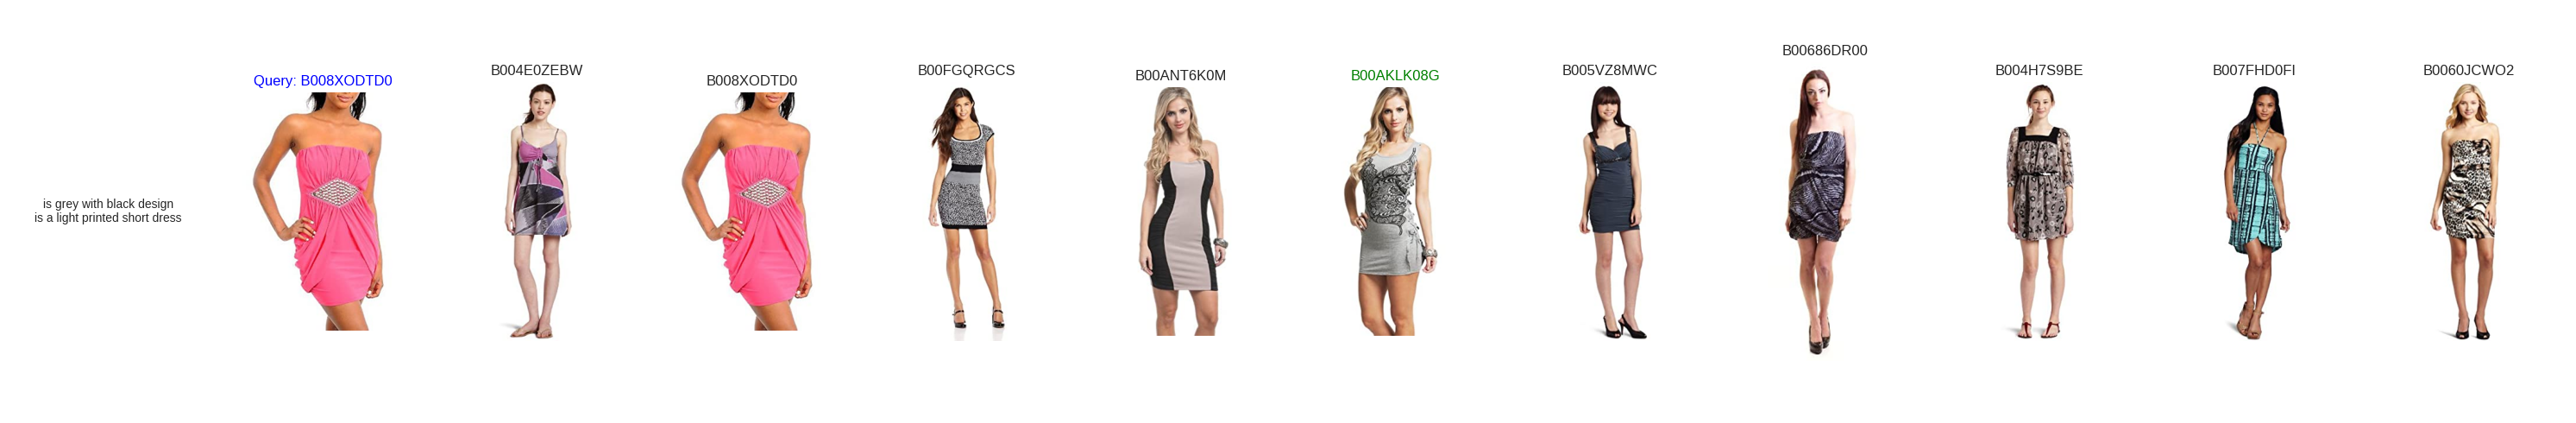

In [63]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=1)

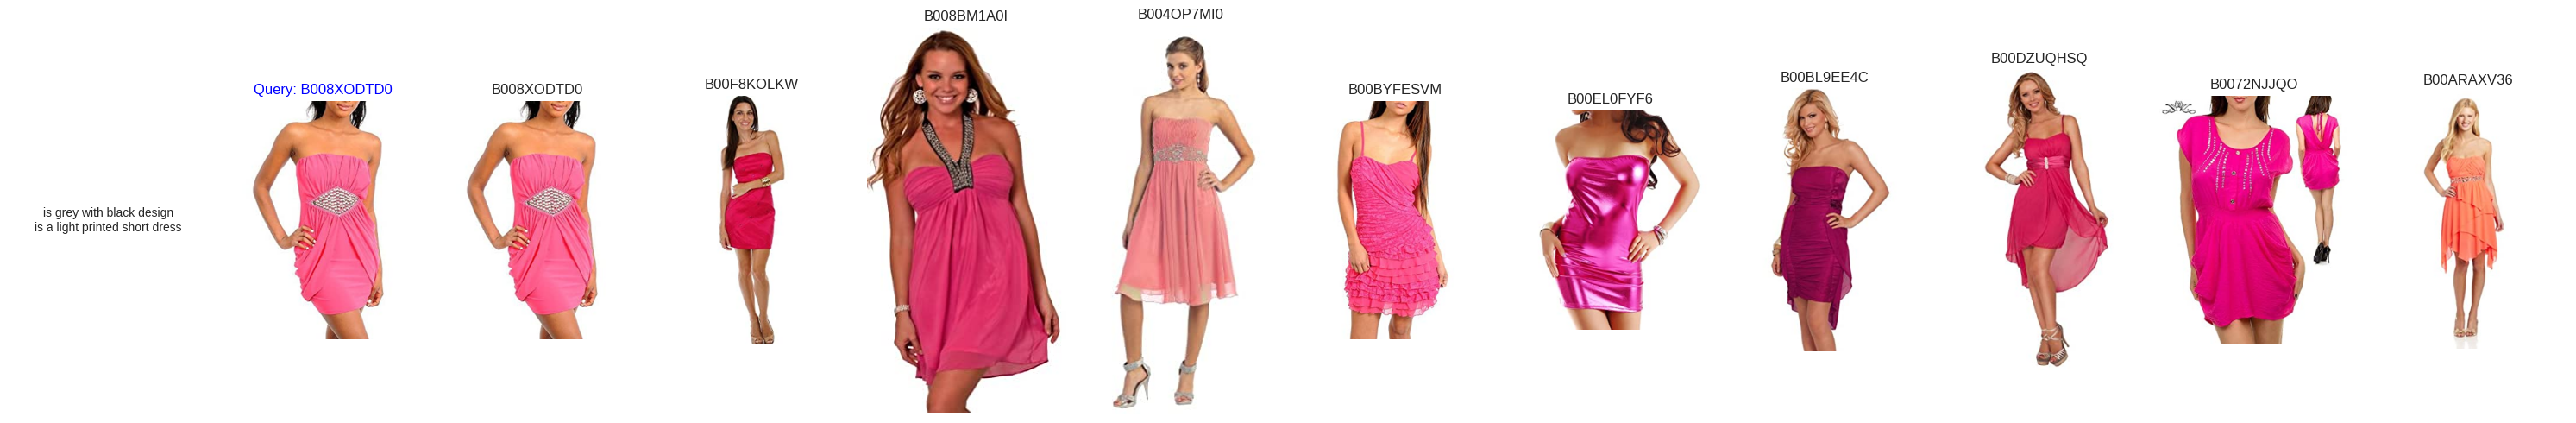

In [64]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=1)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

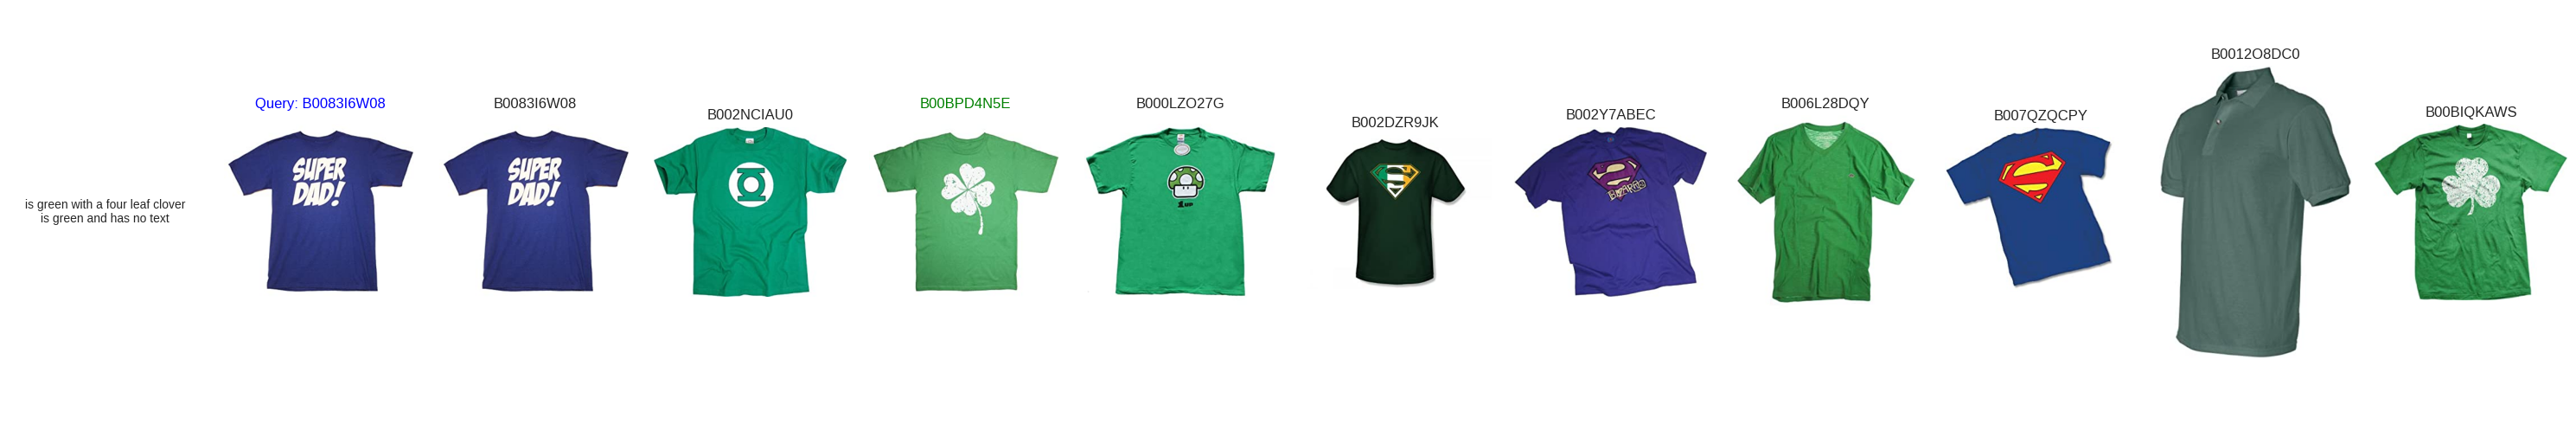

In [59]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1)

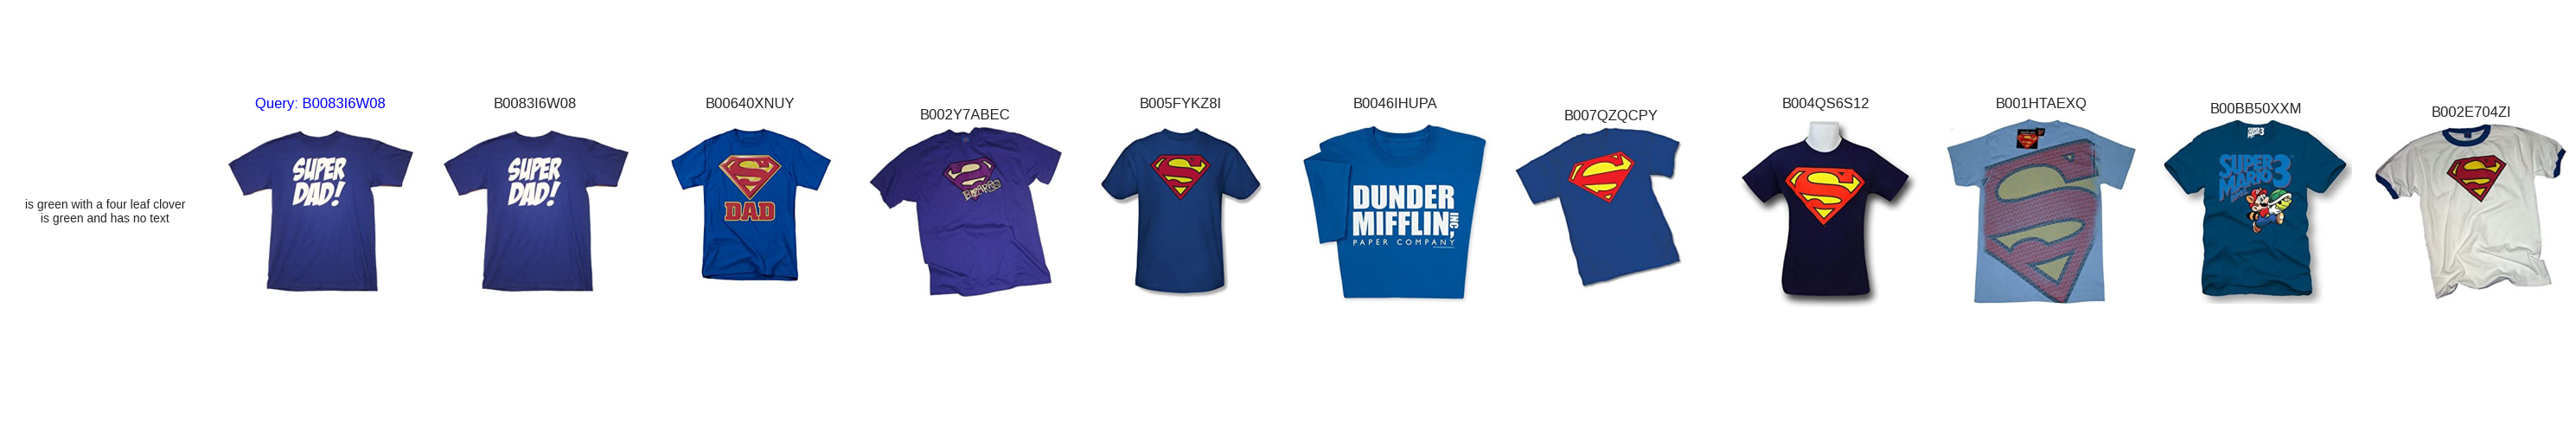

In [60]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

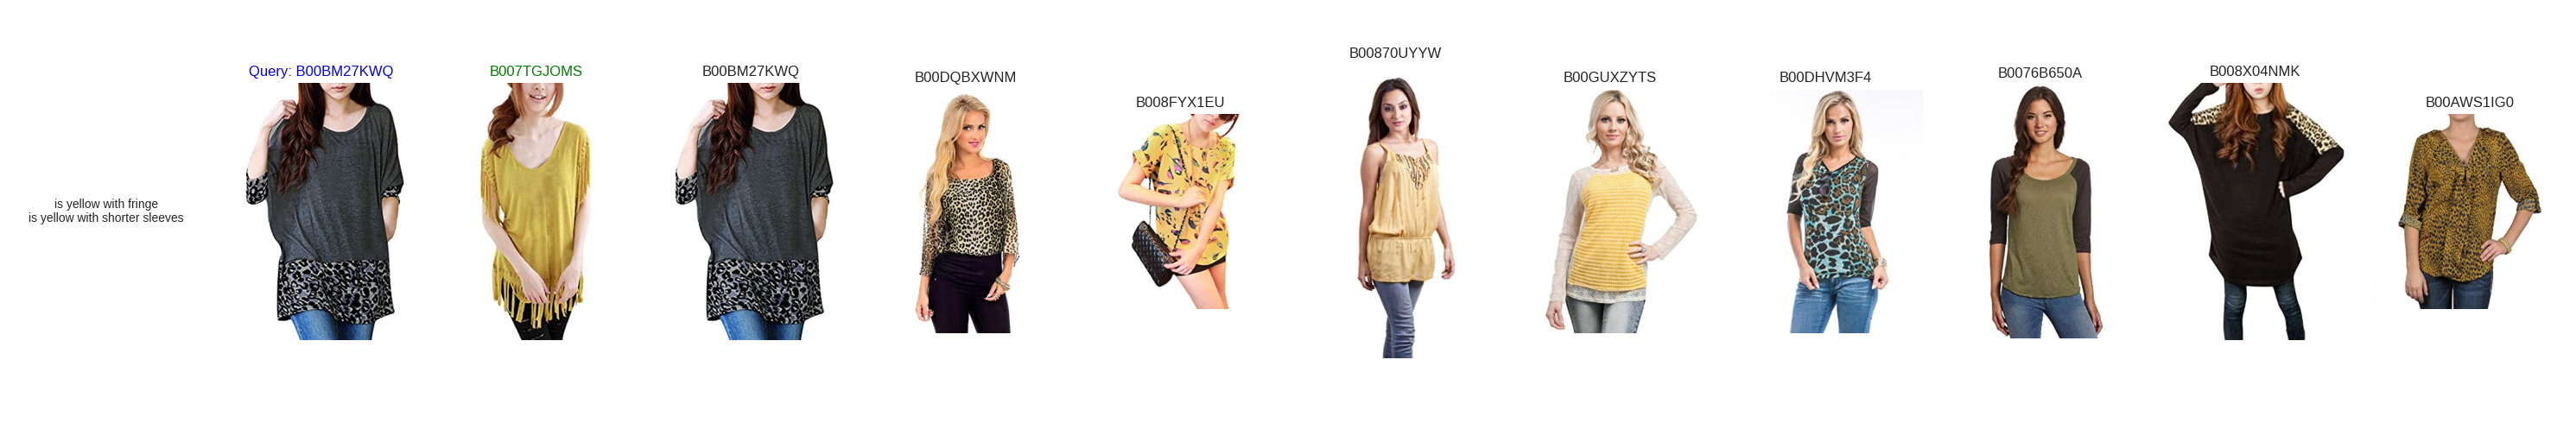

In [61]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2)

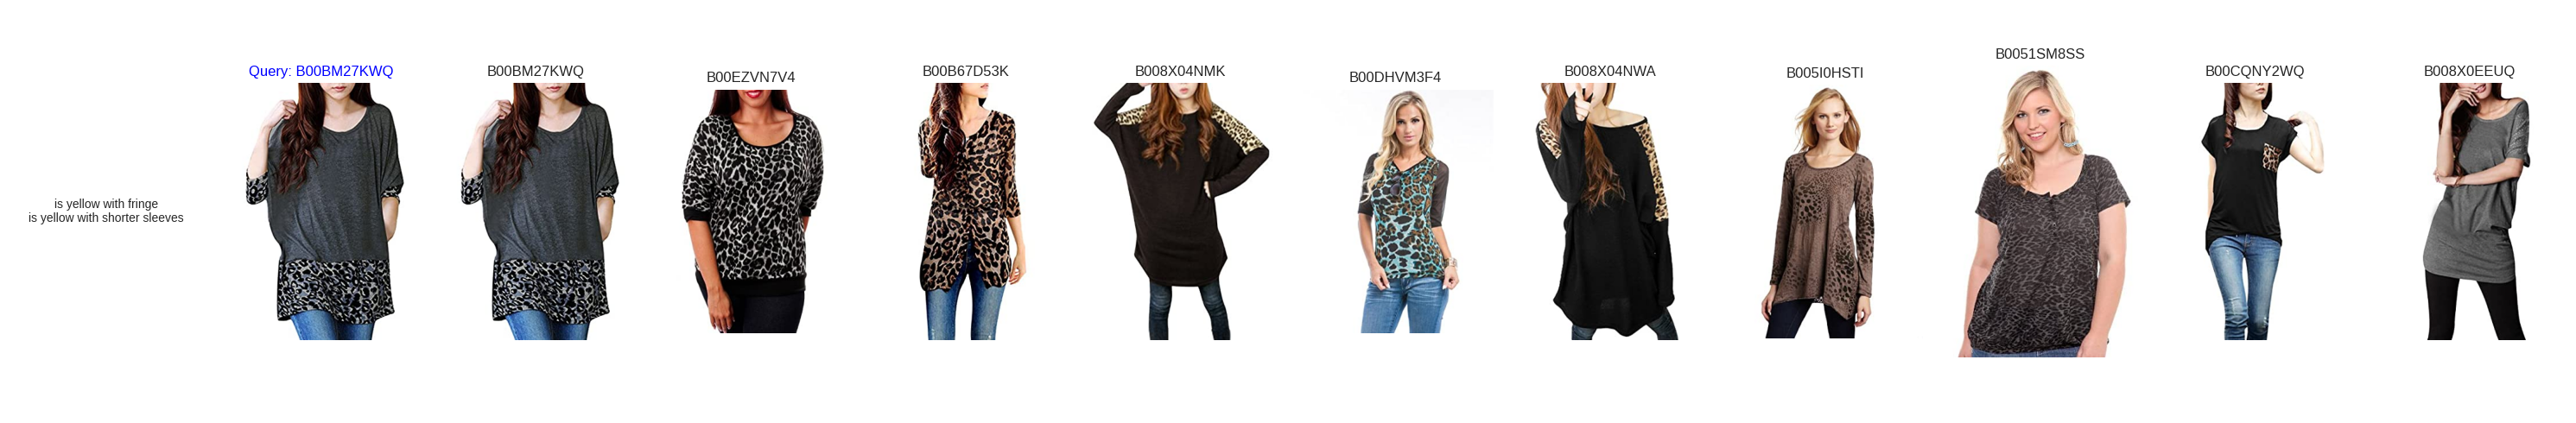

In [62]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2)